In [55]:
# import packages
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import os
import copy
import scipy
from pprint import pprint # for nicer printing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [2]:
# change viewing options
pd.set_option('display.max_columns', None)  
pd.set_option('max_colwidth', -1)

### Step 1: Import data

In [3]:
# read in the data
train = pd.read_csv("training_set_features.csv")
train_labels = pd.read_csv("training_set_labels.csv")
test = pd.read_csv("test_set_features.csv")

### Step 2: Do data preprocessing, scaling, etc.

From the data exploration phase, we decided which columns were relevant to our analysis. 

So, we'll subset the training and test sets by these features

In [4]:
# get columns to subset
columns_subset = ['h1n1_concern', 'h1n1_knowledge', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 
                 'chronic_med_condition', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 
                 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 
                 'opinion_seas_sick_from_vacc', 'age_group', 'education', 'income_poverty']

In [5]:
# subset datasets
train_subset = train.loc[:, columns_subset]
test_subset = test.loc[:, columns_subset]

From the data imputation phase, we decided on a method to impute NaNs in our dataset

In [6]:
# split numeric and non-numeric columns
train_subset_numeric = train_subset.loc[:, ['h1n1_concern', 'h1n1_knowledge', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 
                 'chronic_med_condition', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 
                 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 
                 'opinion_seas_sick_from_vacc']]

train_subset_str = train_subset.loc[:, [ 'age_group', 'education', 'income_poverty']]

test_subset_numeric = test_subset.loc[:, ['h1n1_concern', 'h1n1_knowledge', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 
                 'chronic_med_condition', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 
                 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 
                 'opinion_seas_sick_from_vacc']]

test_subset_str = test_subset.loc[:, [ 'age_group', 'education', 'income_poverty']]


Imputing numeric columns (using median)

In [7]:
# create imputer objects
imp_train = SimpleImputer(missing_values=np.nan, strategy='median')
imp_test = SimpleImputer(missing_values=np.nan, strategy='median')

# fit imputer objects
train_subset_numeric_imputed = pd.DataFrame(imp_train.fit_transform(train_subset_numeric),
                                            columns = train_subset_numeric.columns)
test_subset_numeric_imputed = pd.DataFrame(imp_test.fit_transform(test_subset_numeric), 
                                           columns = test_subset_numeric.columns)

Use StandardScaler to scale numeric columns

In [10]:
# make scalers for train and test sets
scaler_train = StandardScaler()
scaler_test = StandardScaler()

# fit and transform train, test sets
train_subset_numeric_imputed = pd.DataFrame(scaler_train.fit_transform(train_subset_numeric_imputed), 
                                            columns = train_subset_numeric.columns)

test_subset_numeric_imputed = pd.DataFrame(scaler_test.fit_transform(test_subset_numeric_imputed), 
                                            columns = test_subset_numeric.columns)

Imputing string/categorical columns (using 'unknown' as a fill value)

In [12]:
# create imputer objects
imp_train = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value = 'unknown')
imp_test = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value = 'unknown')

# fit imputer objects
train_subset_str_imputed = pd.DataFrame(imp_train.fit_transform(train_subset_str),
                                            columns = train_subset_str.columns)
train_subset_str_imputed = pd.DataFrame(imp_test.fit_transform(train_subset_str), 
                                           columns = train_subset_str.columns)

Re-joining imputed data

In [13]:
# re-join data
imputed_train = pd.concat([train_subset_numeric_imputed, train_subset_str_imputed], axis = 1)
imputed_test = pd.concat([test_subset_numeric_imputed, train_subset_str_imputed], axis = 1)

### Step 3: Start fitting models

Now we can start fitting models to create our predictions. 

I will try using the following models:
1. Logistic Regression
2. Random Forest
3. Feedforward Neural Network

Before doing so, we have to one-hot-encode the categorical features. The models can only work with numeric data, so we need to transform the string data (e.g., "education", which has values like "college") so that it is numeric. 

We can use label encoding, which replaces each value in a column with a number from 0 to n-1 (with n being the # of unique values). This makes sense for our context since there is a clear ordering in the values of a column (for example, '18-34 years' is clearly less than '35-44 years')

In [14]:
imputed_train['age_group'].value_counts()

65+ Years        6843
55 - 64 Years    5563
45 - 54 Years    5238
18 - 34 Years    5215
35 - 44 Years    3848
Name: age_group, dtype: int64

In [15]:
print(imputed_train.dtypes)

h1n1_concern                   float64
h1n1_knowledge                 float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                      object 
education                      object 
income_poverty                 object 
dtype: object


So, we need to label encode the 'age_group', 'education', and 'income_poverty' columns

First, let's convert them to categories

In [16]:
# first, let's change the objects to categories
imputed_train['age_group'] = imputed_train['age_group'].astype('category')
imputed_train['education'] = imputed_train['education'].astype('category')
imputed_train['income_poverty'] = imputed_train['income_poverty'].astype('category')

##### First, let's look at the 'age_group' column:

This is exactly what we expect, so we can directly use the numeric equivalents of the categories

In [17]:
# replace categories with categorical codes
imputed_train['age_group'] = imputed_train['age_group'].cat.codes

##### Now, let's look at the 'education' column: 

In [18]:
# let's see what the categories look like
imputed_train['education'].cat.categories

Index(['12 Years', '< 12 Years', 'College Graduate', 'Some College',
       'unknown'],
      dtype='object')

These categories aren't in the right order, so we need to rearrange them. 

In [19]:
imputed_train['education'].cat.reorder_categories(['unknown','< 12 Years', '12 Years', 'Some College', 'College Graduate'],
                                                  ordered = True, 
                                                  inplace = True)

Now, let's look at the categories

In [20]:
imputed_train['education'].value_counts() 

College Graduate    10097
Some College        7043 
12 Years            5797 
< 12 Years          2363 
unknown             1407 
Name: education, dtype: int64

We see that they are now in the correct order. Now we can replace the categories with their categorical codes

In [21]:
# replace categories with categorical codes
imputed_train['education'] = imputed_train['education'].cat.codes

##### Finally, let's look at the income_poverty column

In [22]:
# let's see what the categories look like
imputed_train['income_poverty'].cat.categories

Index(['<= $75,000, Above Poverty', '> $75,000', 'Below Poverty', 'unknown'], dtype='object')

These are in the wrong order, so we need to rearrange them

In [23]:
imputed_train['income_poverty'].cat.reorder_categories(['unknown','Below Poverty', '<= $75,000, Above Poverty', '> $75,000'],
                                                       ordered = True, 
                                                       inplace = True)


In [24]:
imputed_train['income_poverty'].cat.categories

Index(['unknown', 'Below Poverty', '<= $75,000, Above Poverty', '> $75,000'], dtype='object')

These are now in the correct order, so we can replace the categories with their categorical codes.

In [25]:
# replace categories with categorical codes
imputed_train['income_poverty'] = imputed_train['income_poverty'].cat.codes


In [26]:
imputed_train.dtypes

h1n1_concern                   float64
h1n1_knowledge                 float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                      int8   
education                      int8   
income_poverty                 int8   
dtype: object

Now, all the columns are numeric in some form. For consistency, let's convert age_group, education, and income_poverty to float64 as well

In [27]:
# changing to float64
imputed_train['age_group'] = imputed_train['age_group'].astype('float64')
imputed_train['education'] = imputed_train['education'].astype('float64')
imputed_train['income_poverty'] = imputed_train['income_poverty'].astype('float64')


#### Let's perform the same data cleaning on the test set

In [28]:
# first, let's change the objects to categories
imputed_test['age_group'] = imputed_test['age_group'].astype('category')
imputed_test['education'] = imputed_test['education'].astype('category')
imputed_test['income_poverty'] = imputed_test['income_poverty'].astype('category')


In [29]:
# replace categories with categorical codes
imputed_test['age_group'] = imputed_test['age_group'].cat.codes

In [30]:
# reorder education categories
imputed_test['education'].cat.reorder_categories(['unknown','< 12 Years', '12 Years', 'Some College', 'College Graduate'],
                                                  ordered = True, 
                                                  inplace = True)

In [31]:
# replace categories with categorical codes
imputed_test['education'] = imputed_test['education'].cat.codes

In [32]:
# reorder income poverty
imputed_test['income_poverty'].cat.reorder_categories(['unknown','Below Poverty', '<= $75,000, Above Poverty', '> $75,000'],
                                                       ordered = True, 
                                                       inplace = True)


In [33]:
# replace categories with categorical codes
imputed_test['income_poverty'] = imputed_test['income_poverty'].cat.codes


In [34]:
# changing to float64
imputed_test['age_group'] = imputed_test['age_group'].astype('float64')
imputed_test['education'] = imputed_test['education'].astype('float64')
imputed_test['income_poverty'] = imputed_test['income_poverty'].astype('float64')


Now, let's split our training set into training and validation sets:

In [35]:
X_train, X_eval, y_train, y_eval = sklearn.model_selection.train_test_split(
    imputed_train,
    train_labels[['h1n1_vaccine', 'seasonal_vaccine']],
    test_size = 0.25,
    shuffle = True,
    stratify = train_labels[['h1n1_vaccine', 'seasonal_vaccine']],
    random_state = 100
)

Now, let's also create a function to evaluate the performance of our predictions. The competition evaluates our performance using a ROC-AUC curve, so we'll create a wrapper function on top of sklearn's roc-auc-curve function (the inspiration coming from this link: https://www.drivendata.co/blog/predict-flu-vaccine-data-benchmark/)

In [36]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

#### Logistic Regression

Let's first fit a logistic regression to make predictions for both vaccines

In [37]:
# create model, fit
clf_logReg_h1n1 = LogisticRegression().fit(X_train, y_train['h1n1_vaccine'])


/Users/mark/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [38]:
# get predictions
preds_logReg_h1n1 = clf_logReg_h1n1.predict_proba(X_eval)

Now, let's fit a logistic regression to make predictions for seasonal vaccine adoption.

In [39]:
# create model, fit
clf_logReg_seas = LogisticRegression().fit(X_train, y_train['seasonal_vaccine'])


/Users/mark/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [40]:
# get predictions
preds_logReg_seas = clf_logReg_seas.predict_proba(X_eval)

Now, let's evaluate their results

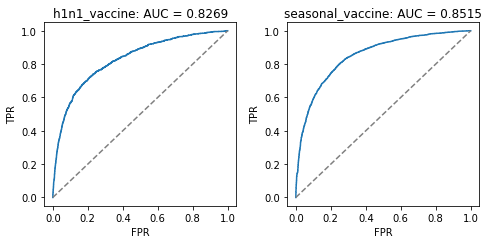

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_eval['h1n1_vaccine'], 
    preds_logReg_h1n1[:, 1], 
    'h1n1_vaccine',
    ax=ax[0]
)
plot_roc(
    y_eval['seasonal_vaccine'], 
    preds_logReg_seas[:, 1], 
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

Now, let's get the roc-auc score directly for both categories:

In [42]:
y_preds = np.transpose(np.array([preds_logReg_h1n1[:, 1], preds_logReg_seas[:, 1]]))

In [43]:
roc_auc_score(y_eval, y_preds)


0.839203920512461

Now, let's create a model on the full training set and then use that model to make predictions on the test set

In [44]:
# train both classifiers, fit
clf_logReg_h1n1_test = LogisticRegression().fit(imputed_train, train_labels['h1n1_vaccine'])
clf_logReg_seas_test = LogisticRegression().fit(imputed_train, train_labels['seasonal_vaccine'])

# get predictions
preds_logReg_h1n1_test = clf_logReg_h1n1_test.predict_proba(imputed_test)
preds_logReg_seas_test = clf_logReg_seas_test.predict_proba(imputed_test)



/Users/mark/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mark/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Now, let's get the predictions

In [45]:
preds_logReg_h1n1_test.shape

(26708, 2)

In [46]:
preds_logReg_h1n1_test[:, 1]

array([0.14746776, 0.06218743, 0.35551725, ..., 0.17226676, 0.052035  ,
       0.46069349])

In [47]:
# get predictions as a np array
y_preds = np.transpose(np.array([test['respondent_id'], preds_logReg_h1n1_test[:, 1], preds_logReg_seas_test[:, 1]]))


In [48]:
y_preds.shape

(26708, 3)

In [49]:
# turn into pd dataframe
y_preds = pd.DataFrame(y_preds, columns = ['respondent_id', 'h1n1_vaccine', 'seasonal_vaccine'])


In [50]:
# change respondent IDs to ints
y_preds['respondent_id'] = y_preds['respondent_id'].astype('int')

In [51]:
# set respondent IDs as index
y_preds.set_index('respondent_id')

h1n1_vaccine  seasonal_vaccine
respondent_id                                
26707          0.147468      0.418227        
26708          0.062187      0.131171        
26709          0.355517      0.449083        
26710          0.487408      0.885526        
26711          0.177724      0.464618        
...                 ...           ...        
53410          0.342793      0.408710        
53411          0.074220      0.464003        
53412          0.172267      0.261014        
53413          0.052035      0.522834        
53414          0.460693      0.234139        

[26708 rows x 2 columns]

In [52]:
# export as csv
#y_preds.to_csv('submissions/submission_1.csv')
y_preds.to_csv('submissions/submission_4.csv') # for standardScaled data

Next steps: we can tinker with some of the logistic regression parameters and see if it improves performance

First, I'll create a generic function to fit models

In [72]:
def model_fitter(model, X_train, y_train, X_eval):
    """
        Wrapper function to train and fit models
        
        Args:
            • model: initialized model object
            • X_train: training set
            • y_train: labels for training set
            • X_eval: evaluation set
            
        Output:
            • preds: returns model predictions, as probability
    """
    
    # fit model
    fitted_model = model.fit(X_train, y_train)
    
    # get predictions
    preds = fitted_model.predict_proba(X_eval)
    
    # return predictions
    return preds

Now, let's try a logistic regression, with CV and different solvers

In [76]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

Fitting logistic regression for newton-cg
Fitting logistic regression for lbfgs
Fitting logistic regression for liblinear
Fitting logistic regression for sag
Fitting logistic regression for saga


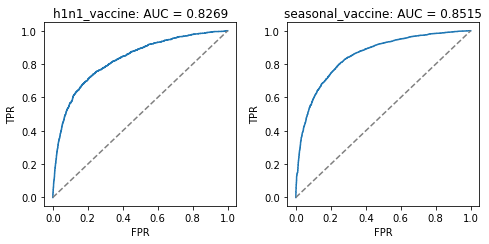

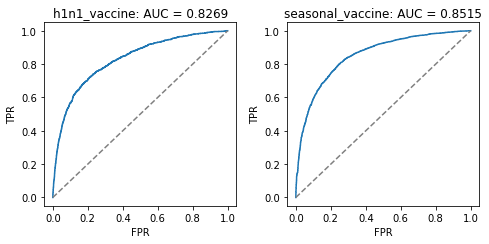

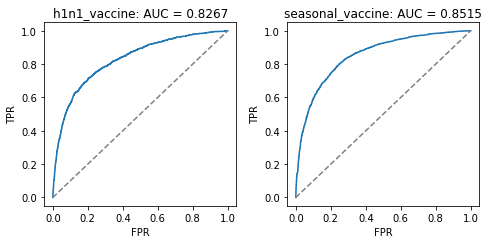

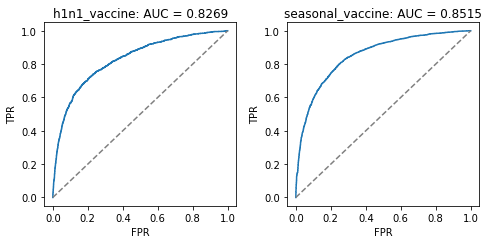

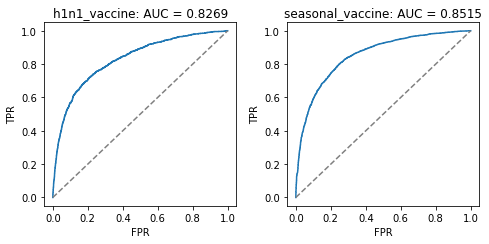

In [87]:
for solver in solvers:
    
    print(f"Fitting logistic regression for {solver}")
    # initialize classifiers:
    clf_h1n1 = sklearn.linear_model.LogisticRegressionCV(solver=solver, 
                                                         cv = 5,
                                                         scoring="roc_auc",
                                                         max_iter=1000)

    clf_seas = sklearn.linear_model.LogisticRegressionCV(solver=solver, 
                                                         cv = 5,
                                                         scoring="roc_auc",
                                                         max_iter=1000)

    # fit, get preds
    preds_h1n1 = model_fitter(clf_h1n1, X_train, y_train['h1n1_vaccine'], X_eval)
    preds_seas = model_fitter(clf_seas, X_train, y_train['seasonal_vaccine'], X_eval)
    
    # plot
    fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

    plot_roc(
        y_eval['h1n1_vaccine'], 
        preds_h1n1[:, 1], 
        'h1n1_vaccine',
        ax=ax[0]
    )
    plot_roc(
        y_eval['seasonal_vaccine'], 
        preds_seas[:, 1], 
        'seasonal_vaccine',
        ax=ax[1]
    )
    fig.tight_layout()
    
    del fig, ax, clf_h1n1, clf_seas, preds_h1n1, preds_seas
    
    print("==========================")

Choice of solver doesn't seem to make much difference in the results?

#### Random Forest

We can use the data from the previous section and fit a random forest classifier. 

We will need to use grid search and cross-validation to tune our random forest

First, I'll use the default parameters for random forest, fit a model based off this. Then, I'll use grid search + cv to improve our parameter.

In [140]:
# fit random forest classifier for h1n1 vaccine
clf_rf_h1n1 = RandomForestClassifier()
clf_rf_h1n1.fit(X_train, y_train['h1n1_vaccine'])
preds_rf_h1n1 = clf_rf_h1n1.predict_proba(X_eval)

/Users/mark/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [141]:
# fit random forest classifier for seasonal vaccine
clf_rf_seas = RandomForestClassifier()
clf_rf_seas.fit(X_train, y_train['seasonal_vaccine'])
preds_rf_seas = clf_rf_seas.predict_proba(X_eval)

/Users/mark/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


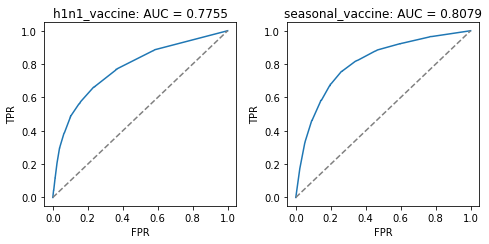

In [142]:
# evaluate results
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_eval['h1n1_vaccine'], 
    preds_rf_h1n1[:, 1], 
    'h1n1_vaccine',
    ax=ax[0]
)
plot_roc(
    y_eval['seasonal_vaccine'], 
    preds_rf_seas[:, 1], 
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

Now, let's create this for the test set

In [143]:
# train both classifiers, fit
clf_rf_h1n1_test = RandomForestClassifier().fit(imputed_train, train_labels['h1n1_vaccine'])
clf_rf_seas_test = RandomForestClassifier().fit(imputed_train, train_labels['seasonal_vaccine'])

# get predictions
preds_rf_h1n1_test = clf_rf_h1n1_test.predict_proba(imputed_test)
preds_rf_seas_test = clf_rf_seas_test.predict_proba(imputed_test)



/Users/mark/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mark/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [144]:
# get predictions as a np array
y_preds = np.transpose(np.array([test['respondent_id'], preds_rf_h1n1_test[:, 1], preds_rf_seas_test[:, 1]]))


In [145]:
# turn into pd dataframe
y_preds = pd.DataFrame(y_preds, columns = ['respondent_id', 'h1n1_vaccine', 'seasonal_vaccine'])


In [146]:
# change respondent IDs to ints
y_preds['respondent_id'] = y_preds['respondent_id'].astype('int')

In [147]:
# export as csv
y_preds.to_csv('submissions/submission_2.csv')

Now, let's use (randomized) grid search and cross-validation to improve our hyperparameters

First, we define a range for each of our parameters that we want to tune

In [89]:
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 40, num = 10)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

Now, let's define the random grid of parameters

In [90]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [94]:
pprint.pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 13, 16, 20, 23, 26, 30, 33, 36, 40, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [101]:
# create the base model
rf = RandomForestClassifier()

# Random search, 5 fold cross validation, search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 5, 
                               verbose=2, 
                               random_state=100, 
                               n_jobs = -1)

# make copy, for seasonal vaccine model
rf_random_seas = copy.deepcopy(rf_random)

# Fit the random search models
rf_random.fit(X_train, y_train['h1n1_vaccine'])
rf_random_seas.fit(X_train, y_train['seasonal_vaccine'])


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 41.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 93.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 150.3min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 48.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 116.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 162.0min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

Evaluate performance of random search model:

In [105]:
# get predictions
preds_rf_h1n1 = rf_random.predict_proba(X_eval)
preds_rf_seas = rf_random_seas.predict_proba(X_eval)

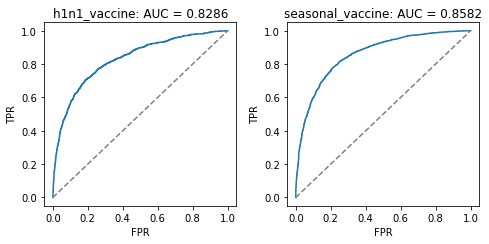

In [106]:
# evaluate results
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_eval['h1n1_vaccine'], 
    preds_rf_h1n1[:, 1], 
    'h1n1_vaccine',
    ax=ax[0]
)
plot_roc(
    y_eval['seasonal_vaccine'], 
    preds_rf_seas[:, 1], 
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

Let's look at the parameters used:

In [107]:
pprint(rf_random.best_params_)

{'bootstrap': True,
 'max_depth': 23,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 400}


So, from the randomized grid search process, the best results came with the following parameters:
1. bootstrap: True
2. max_depth: 23
3. max_features: auto
4. min_samples_leaf: 4
5. min_samples_split: 5
6. n_estimators: 400

Now, let's get predictions for the test set

In [90]:
def get_predictions_test_set(model_h1n1, model_seas, X_test):
    
    """
        Get predictions on test set
        Args:
            • model_h1n1: trained h1n1 vaccine model
            • model_seas: trained seasonal vaccine model
            • X_test: test set
            
        Output:
            • preds: df with predictions
    """
    
    # get predictions on test set
    preds_h1n1_test = model_h1n1.predict_proba(X_test)
    preds_seas_test = model_seas.predict_proba(X_test)
    
    # get predictions as numpy array
    y_preds = np.transpose(np.array([test['respondent_id'], preds_h1n1_test[:, 1], preds_seas_test[:, 1]]))
    
    # turn into pandas df
    y_preds = pd.DataFrame(y_preds, columns = ['respondent_id', 'h1n1_vaccine', 'seasonal_vaccine'])
    
    # change respondent IDs to ints
    y_preds['respondent_id'] = y_preds['respondent_id'].astype('int')
    
    # return predictions
    return y_preds

In [109]:
# get predictions
y_preds = get_predictions_test_set(rf_random, rf_random_seas, imputed_test)

In [111]:
# export predictions
y_preds.to_csv('submissions/submission_3.csv')

Using randomized search gives us a better idea of the range that we should consider for our parameters. We can make our search more focused by using grid search and cross-validation, which will give us a more exhaustive/brute-force based solution

From above, we know that the randomized grid search came to the following parameters:

1. bootstrap: True
2. max_depth: 23
3. max_features: auto
4. min_samples_leaf: 4
5. min_samples_split: 5
6. n_estimators: 400


In [78]:
# get parameters for grid search
tuning_parameters = [{'bootstrap' : [True], 
                      'max_depth' : [15, 20, 25, 30], 
                      'max_features' : ['auto'], 
                      'min_samples_leaf' : [int(x) for x in np.linspace(2, 10, num = 5, endpoint = True)], 
                      'min_samples_split' : [int(x) for x in np.linspace(5, 20, num = 4, endpoint = True)], 
                      'n_estimators' : [int(x) for x in np.linspace(50, 550, num = 6, endpoint = True)]}]

In [79]:
# train classifier using grid search
rf_clf_h1n1 = GridSearchCV(RandomForestClassifier(), tuning_parameters, 
                           iid = True, 
                           cv = 5, 
                           refit = True, 
                           verbose = 5)




In [82]:
# make copy, for seasonal vaccine model
rf_clf_seas = copy.deepcopy(rf_clf_h1n1)



In [81]:
# fit to data
rf_clf_h1n1.fit(X_train, y_train['h1n1_vaccine'])

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.825, total=   0.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.829, total=   0.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.835, total=   0.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s


[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.833, total=   1.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.3s remaining:    0.0s


[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.834, total=   0.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150, score=0.829, total=   2.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150, score=0.828, total=   1.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150, score=0.834, total=   2.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_e

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=150, score=0.836, total=   2.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=150, score=0.836, total=   2.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=150, score=0.836, total=   2.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=250 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=250, score=0.829, total=   4.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=250, score=0.831, total=   2.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=250 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=250, score=0.830, total=   2.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=250 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=250, score=0.838, total=   2.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=250 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=250, score=0.834, total=   2.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=250, score=0.834, total=   4.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=250 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=250, score=0.837, total=   7.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=350 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=350, score=0.831, total=  11.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=350 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=350, score=0.828, total=   6.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=350, score=0.826, total=   4.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=350 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=350, score=0.838, total=   3.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=350 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=350, score=0.835, total=   3.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=350 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=350, score=0.835, total=   3.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=350, score=0.835, total=   8.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=450 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=450, score=0.828, total=  14.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=450 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=450, score=0.830, total=  13.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=450 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=450, score=0.838, total=   9.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=450, score=0.837, total=   4.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=450 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=450, score=0.833, total=   4.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=450 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=450, score=0.836, total=   4.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=550 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=550, score=0.829, total=   5.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=550, score=0.829, total=   5.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=550 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=550, score=0.828, total=   5.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=550 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=550, score=0.838, total=   5.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=550 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=550, score=0.834, total=   5.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=550, score=0.833, total=   5.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=550 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=550, score=0.834, total=   5.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=50, score=0.829, total=   0.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=50, score=0.830, total=   0.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=10, n

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=50, score=0.829, total=   0.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=50 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=50, score=0.835, total=   0.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=50 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=50, score=0.833, total=   0.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=50 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=50, score=0.834, total=   0.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=15, n

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=50, score=0.836, total=   0.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=150 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=150, score=0.831, total=   1.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=150 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=150, score=0.830, total=   1.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=150 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=150, score=0.835, total=   1.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=150, score=0.835, total=   1.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=150 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=150, score=0.833, total=   1.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=150 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=150, score=0.832, total=   1.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=250 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=250, score=0.829, total=   2.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=250, score=0.831, total=   2.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=250 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=250, score=0.827, total=   2.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=250 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=250, score=0.834, total=   2.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=250 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=250, score=0.832, total=   2.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=250, score=0.834, total=   4.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=250 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=250, score=0.834, total=   2.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=350 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=350, score=0.829, total=   3.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=350 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=350, score=0.828, total=   4.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=350, score=0.828, total=   3.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=350 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=350, score=0.836, total=   3.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=350 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=350, score=0.833, total=   3.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=350 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=350, score=0.833, total=   3.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=350, score=0.833, total=   3.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=450 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=450, score=0.831, total=   4.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=450 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=450, score=0.826, total=   4.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=450 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=450, score=0.835, total=   4.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=450, score=0.827, total=   4.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=450 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=450, score=0.836, total=   4.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=450 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=450, score=0.830, total=   4.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=450 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=450, score=0.832, total=   4.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=450, score=0.831, total=   4.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=450 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=450, score=0.833, total=   4.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=550 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=550, score=0.830, total=   5.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=550 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=550, score=0.828, total=   5.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=550, score=0.831, total=   5.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=550 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=550, score=0.827, total=   5.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=550 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=550, score=0.834, total=   5.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=550 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=550, score=0.831, total=   5.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=550, score=0.833, total=   6.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=550 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=550, score=0.834, total=   6.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50, score=0.830, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50, score=0.825, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=50, score=0.828, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=50, score=0.834, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=50, score=0.829, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=50, score=0.834, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=15, n

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=50, score=0.836, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=150, score=0.830, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=150, score=0.828, total=   1.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=150, score=0.836, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=150, score=0.836, total=   1.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=150, score=0.830, total=   1.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=150, score=0.835, total=   1.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=250 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=250, score=0.828, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=250, score=0.828, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=250 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=250, score=0.826, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=250 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=250, score=0.837, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=250 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=250, score=0.833, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=250, score=0.835, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=250 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=250, score=0.833, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=350 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=350, score=0.829, total=   3.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=350 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=350, score=0.828, total=   3.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=350, score=0.828, total=   3.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=350 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=350, score=0.835, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=350 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=350, score=0.833, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=350 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=350, score=0.835, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=350, score=0.835, total=   3.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=450 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=450, score=0.829, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=450 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=450, score=0.830, total=   4.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=450 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=450, score=0.836, total=   4.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=450, score=0.835, total=   5.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=450 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=450, score=0.832, total=   6.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=450 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=450, score=0.836, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=550 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=550, score=0.830, total=   6.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=550, score=0.831, total=   6.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=550 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=550, score=0.829, total=   5.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=550 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=550, score=0.835, total=   5.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=550 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=550, score=0.834, total=   5.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=550, score=0.833, total=   5.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=550 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=550, score=0.833, total=   5.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=50, score=0.829, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=50, score=0.828, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_e

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=50, score=0.830, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=50, score=0.834, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=50, score=0.832, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=50, score=0.836, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=10, n

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=50, score=0.831, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=150, score=0.831, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=150, score=0.827, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=150, score=0.837, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=150, score=0.835, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=150, score=0.832, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=150, score=0.836, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=250 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=250, score=0.830, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=250, score=0.829, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=250 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=250, score=0.828, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=250 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=250, score=0.839, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=250 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=250, score=0.831, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=250, score=0.835, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=250 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=250, score=0.832, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=250 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=250, score=0.834, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=350 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=350, score=0.830, total=   5.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=250, score=0.833, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=350 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=350, score=0.831, total=   3.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=350 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=350, score=0.827, total=   3.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=350 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=350, score=0.835, total=   3.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=350, score=0.827, total=   3.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=350 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=350, score=0.835, total=   3.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=350 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=350, score=0.832, total=   3.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=350 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=350, score=0.834, total=   3.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=350, score=0.833, total=   4.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=450 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=450, score=0.826, total=   5.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=450 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=450, score=0.827, total=   5.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=450 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=450, score=0.836, total=   5.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=450, score=0.837, total=   4.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=450 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=450, score=0.836, total=   4.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=450 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=450, score=0.833, total=   4.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=550 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=550, score=0.830, total=   6.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=550, score=0.830, total=   5.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=550 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=550, score=0.828, total=   5.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=550 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=550, score=0.836, total=   5.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=550 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=550, score=0.835, total=   6.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=550, score=0.834, total=   8.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=550 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=550, score=0.835, total=   6.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50, score=0.830, total=   0.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50, score=0.826, total=   0.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_e

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50, score=0.830, total=   0.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50, score=0.835, total=   0.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50, score=0.833, total=   0.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50, score=0.839, total=   0.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=10, n

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=50, score=0.835, total=   0.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=150 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=150, score=0.830, total=   1.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=150 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=150, score=0.828, total=   1.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=150 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=150, score=0.835, total=   1.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=150, score=0.835, total=   1.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=150 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=150, score=0.832, total=   1.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=150 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=150, score=0.834, total=   1.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=250 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=250, score=0.832, total=   2.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=250, score=0.830, total=   2.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=250 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=250, score=0.830, total=   2.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=250 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=250, score=0.837, total=   2.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=250 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=250, score=0.832, total=   2.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=250, score=0.832, total=   2.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=250 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=250, score=0.834, total=   2.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=350 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=350, score=0.829, total=   4.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=350 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=350, score=0.829, total=   4.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=350, score=0.828, total=   3.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=350 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=350, score=0.836, total=   3.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=350 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=350, score=0.833, total=   3.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=350 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=350, score=0.835, total=   3.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=350, score=0.834, total=   3.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=450 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=450, score=0.830, total=   4.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=450 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=450, score=0.829, total=   4.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=450 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=450, score=0.836, total=   4.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=450, score=0.835, total=   4.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=450 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=450, score=0.833, total=   4.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=450 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=450, score=0.835, total=   4.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=550 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=550, score=0.831, total=   5.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=550, score=0.828, total=   6.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=550 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=550, score=0.828, total=   5.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=550 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=550, score=0.835, total=   5.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=550 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=550, score=0.832, total=   6.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=550, score=0.832, total=   5.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=550 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=550, score=0.833, total=   5.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=50 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=50, score=0.831, total=   0.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=50 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=50, score=0.826, total=   0.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=20

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=50, score=0.830, total=   0.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=50, score=0.836, total=   0.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=50, score=0.830, total=   0.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=50, score=0.835, total=   0.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=50, score=0.836, total=   0.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=150, score=0.830, total=   1.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=150, score=0.831, total=   1.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=150, score=0.835, total=   1.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_sampl

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=150, score=0.829, total=   1.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=150 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=150, score=0.837, total=   1.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=150 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=150, score=0.834, total=   1.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=150 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=150, score=0.834, total=   1.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=150, score=0.832, total=   1.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=150 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=150, score=0.835, total=   1.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=250 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=250, score=0.831, total=   2.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=250 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=250, score=0.827, total=   2.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=250, score=0.827, total=   3.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=250 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=250, score=0.826, total=   3.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=250 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=250, score=0.834, total=   3.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=250 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=250, score=0.831, total=   3.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=250, score=0.835, total=   3.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=250 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=250, score=0.834, total=   3.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=350 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=350, score=0.828, total=   4.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=350 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=350, score=0.828, total=   4.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=350, score=0.828, total=   4.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=350 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=350, score=0.836, total=   4.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=350 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=350, score=0.834, total=   4.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=350 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=350, score=0.836, total=   4.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=350, score=0.834, total=   4.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=450 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=450, score=0.830, total=   5.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=450 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=450, score=0.828, total=   5.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=450 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=450, score=0.838, total=   5.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=450, score=0.837, total=   4.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=450 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=450, score=0.833, total=   4.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=450 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=450, score=0.835, total=   5.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=550 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=550, score=0.830, total=   6.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=550, score=0.830, total=   5.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=550 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=550, score=0.829, total=   5.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=550 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=550, score=0.838, total=   7.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=550 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=550, score=0.834, total=   6.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_spli

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=550, score=0.832, total=   7.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=550 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=550, score=0.834, total=   6.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=50 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=50, score=0.832, total=   0.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=50 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=50, score=0.827, total=   0.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=20

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=50, score=0.829, total=   0.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=50, score=0.832, total=   0.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=50, score=0.836, total=   0.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=50, score=0.834, total=   0.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimat

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=50, score=0.835, total=   0.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=150, score=0.828, total=   1.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=150, score=0.828, total=   1.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=150, score=0.838, total=   1.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=150, score=0.837, total=   1.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=150 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=150, score=0.834, total=   1.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=150 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=150, score=0.834, total=   1.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=250 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=250, score=0.832, total=   2.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_spli

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=250, score=0.830, total=   2.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=250 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=250, score=0.829, total=   2.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=250 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=250, score=0.834, total=   2.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=250 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=250, score=0.833, total=   2.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_spli

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=250, score=0.831, total=   2.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=250 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=250, score=0.834, total=   2.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=350 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=350, score=0.830, total=   3.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=350 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=350, score=0.830, total=   3.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=350, score=0.829, total=   3.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=350 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=350, score=0.835, total=   3.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=350 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=350, score=0.833, total=   3.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=350 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=350, score=0.834, total=   3.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_spli

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=350, score=0.834, total=   3.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=450 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=450, score=0.830, total=   4.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=450 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=450, score=0.828, total=   4.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=450 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=450, score=0.835, total=   4.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_spli

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=450, score=0.836, total=   4.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=450 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=450, score=0.833, total=   4.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=450 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=450, score=0.833, total=   5.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=550 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=550, score=0.831, total=   5.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_spli

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=550, score=0.830, total=   5.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=550 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=550, score=0.827, total=   5.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=550 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=550, score=0.836, total=39.4min
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=550 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=550, score=0.831, total=  12.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=550, score=0.835, total=   5.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=550 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=550, score=0.833, total=   5.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=550 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=550, score=0.834, total=   5.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=50 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=50, score=0.831, total=   0.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_sample

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=550, score=0.835, total=   5.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=50 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=50, score=0.827, total=   0.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=50 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=50, score=0.826, total=   0.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=50 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=50, score=0.835, total=   0.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_sp

[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed: 173.7min finished


Fitting 5 folds for each of 4000 candidates, totalling 20000 fits
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.768, total=   0.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.774, total=   0.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.765, total=   0.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.8s remaining:    0.0s


[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.773, total=   0.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.4s remaining:    0.0s


[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.758, total=   0.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=55 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=55, score=0.765, total=   0.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=55 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=55, score=0.771, total=   0.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=55 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=55, score=0.768, total=   0.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimat

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=85, score=0.768, total=   1.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=85 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=85, score=0.772, total=   1.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=85 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=85, score=0.760, total=   1.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90, score=0.771, total=   1.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimat

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=120, score=0.772, total=   1.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=120 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=120, score=0.773, total=   1.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=120 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=120, score=0.767, total=   1.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=120 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=120, score=0.772, total=   1.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=151, score=0.773, total=   1.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=151 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=151, score=0.761, total=   1.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=156 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=156, score=0.769, total=   1.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=156 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=156, score=0.777, total=   1.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=186, score=0.773, total=   2.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=186 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=186, score=0.767, total=   2.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=186 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=186, score=0.775, total=   2.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=186 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=186, score=0.757, total=   2.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=216, score=0.759, total=   2.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=221 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=221, score=0.771, total=   2.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=221 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=221, score=0.776, total=   2.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=221 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=221, score=0.769, total=   2.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=252, score=0.770, total=   3.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=252 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=252, score=0.772, total=   3.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=252 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=252, score=0.761, total=   2.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=257 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=257, score=0.772, total=   3.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=287, score=0.770, total=   3.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=287 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=287, score=0.774, total=   3.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=287 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=287, score=0.767, total=   3.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=287 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=287, score=0.773, total=   3.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=317, score=0.771, total=   3.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=317 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=317, score=0.760, total=   3.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=322 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=322, score=0.769, total=   4.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=322 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=322, score=0.772, total=   3.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=353, score=0.775, total=   4.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=353 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=353, score=0.766, total=   4.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=353 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=353, score=0.772, total=   4.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=353 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=353, score=0.760, total=   4.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=383, score=0.759, total=   4.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=388 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=388, score=0.772, total=   4.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=388 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=388, score=0.774, total=   4.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=388 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=388, score=0.769, total=   4.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=418, score=0.767, total=   5.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=418 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=418, score=0.772, total=   6.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=418 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=418, score=0.762, total=   5.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=423 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=423, score=0.773, total=   5.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=454, score=0.771, total=   5.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=454 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=454, score=0.775, total=   5.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=454 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=454, score=0.769, total=   5.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=454 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=454, score=0.773, total=   5.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=484, score=0.770, total=   5.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=484 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=484, score=0.762, total=   6.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=489 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=489, score=0.770, total=   5.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=489 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=489, score=0.776, total=   5.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=519, score=0.773, total=   6.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=519 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=519, score=0.770, total=   6.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=519 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=519, score=0.773, total=   5.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=519 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=519, score=0.761, total=   5.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=550, score=0.761, total=   6.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=50, score=0.772, total=   0.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=50, score=0.769, total=   0.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=50, score=0.767, total=   0.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estima

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=80, score=0.768, total=   0.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=80 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=80, score=0.772, total=   0.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=80 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=80, score=0.759, total=   0.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=85 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=85, score=0.772, total=   0.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimat

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=115, score=0.768, total=   1.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=115 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=115, score=0.777, total=   1.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=115 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=115, score=0.770, total=   1.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=115 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=115, score=0.771, total=   1.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=145, score=0.774, total=   1.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=145 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=145, score=0.765, total=   1.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=151 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=151, score=0.773, total=   1.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=151 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=151, score=0.777, total=   1.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=181, score=0.775, total=   2.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=181 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=181, score=0.767, total=   2.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=181 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=181, score=0.775, total=   1.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=181 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=181, score=0.763, total=   2.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=211, score=0.762, total=   2.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=216 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=216, score=0.770, total=   2.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=216 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=216, score=0.773, total=   2.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=216 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=216, score=0.767, total=   2.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=246, score=0.767, total=   2.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=246 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=246, score=0.774, total=   2.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=246 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=246, score=0.759, total=   2.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=252 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=252, score=0.775, total=   2.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=282, score=0.773, total=   3.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=282 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=282, score=0.773, total=   3.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=282 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=282, score=0.768, total=   3.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=282 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=282, score=0.775, total=   3.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=312, score=0.777, total=   4.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=312 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=312, score=0.761, total=   3.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=317 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=317, score=0.772, total=   3.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=317 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=317, score=0.777, total=   3.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=347, score=0.774, total=   3.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=347 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=347, score=0.769, total=   3.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=347 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=347, score=0.775, total=   3.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=347 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=347, score=0.760, total=   3.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=378, score=0.758, total=   4.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=383 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=383, score=0.774, total=   4.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=383 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=383, score=0.774, total=   4.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=383 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=383, score=0.767, total=   4.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=413, score=0.767, total=   4.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=413 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=413, score=0.773, total=   4.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=413 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=413, score=0.760, total=   6.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=418 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=418, score=0.772, total=   5.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=448, score=0.772, total=   5.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=448 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=448, score=0.777, total=   5.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=448 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=448, score=0.768, total=   5.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=448 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=448, score=0.775, total=   8.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=479, score=0.774, total=   5.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=479 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=479, score=0.759, total=   5.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=484 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=484, score=0.773, total=   5.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=484 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=484, score=0.775, total=   5.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=514, score=0.776, total=   5.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=514 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=514, score=0.769, total=   5.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=514 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=514, score=0.774, total=   6.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=514 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=514, score=0.761, total=   6.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=544, score=0.760, total=   6.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=550 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=550, score=0.774, total=   6.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=550 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=550, score=0.776, total=   6.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=550 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=550, score=0.768, total=   6.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=75, score=0.773, total=   0.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=75 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=75, score=0.774, total=   0.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=75 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=75, score=0.758, total=   1.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=80 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=80, score=0.770, total=   1.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=110, score=0.772, total=   1.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=110 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=110, score=0.774, total=   1.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=110 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=110, score=0.768, total=   1.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=110 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=110, score=0.774, total=   1.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=140, score=0.772, total=   1.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=140 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=140, score=0.766, total=   1.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=145 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=145, score=0.773, total=   1.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=145 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=145, score=0.775, total=   1.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=176, score=0.774, total=   1.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=176 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=176, score=0.768, total=   1.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=176 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=176, score=0.777, total=   1.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=176 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=176, score=0.762, total=   2.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=206, score=0.761, total=   2.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=211 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=211, score=0.771, total=   2.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=211 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=211, score=0.776, total=   2.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=211 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=211, score=0.768, total=   2.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=241, score=0.770, total=   2.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=241 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=241, score=0.773, total=   2.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=241 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=241, score=0.763, total=   2.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=246 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=246, score=0.773, total=   2.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=277, score=0.773, total=   2.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=277 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=277, score=0.776, total=   3.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=277 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=277, score=0.768, total=   2.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=277 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=277, score=0.777, total=   3.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=307, score=0.777, total=   3.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=307 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=307, score=0.764, total=   3.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=312 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=312, score=0.773, total=   3.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=312 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=312, score=0.774, total=   3.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=342, score=0.776, total=   4.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=342 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=342, score=0.769, total=   4.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=342 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=342, score=0.773, total=   4.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=342 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=342, score=0.763, total=   3.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=373, score=0.762, total=   4.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=378 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=378, score=0.772, total=   4.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=378 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=378, score=0.776, total=   4.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=378 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=378, score=0.771, total=   4.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=408, score=0.771, total=   4.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=408 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=408, score=0.775, total=   4.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=408 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=408, score=0.761, total=   4.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=413 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=413, score=0.777, total=   4.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=443, score=0.774, total=   6.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=443 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=443, score=0.774, total=   6.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=443 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=443, score=0.769, total=   5.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=443 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=443, score=0.774, total=   5.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=474, score=0.774, total=   5.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=474 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=474, score=0.763, total=   5.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=479 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=479, score=0.776, total=   5.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=479 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=479, score=0.773, total=   5.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=509, score=0.775, total=   5.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=509 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=509, score=0.770, total=   5.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=509 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=509, score=0.777, total=   6.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=509 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=509, score=0.763, total=   5.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=539, score=0.762, total=   5.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=544 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=544, score=0.773, total=   5.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=544 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=544, score=0.773, total=   5.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=544 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=544, score=0.769, total=   5.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=70, score=0.765, total=   0.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=70 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=70, score=0.780, total=   0.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=70 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=70, score=0.763, total=   0.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=75 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=75, score=0.772, total=   0.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=105, score=0.772, total=   1.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=105 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=105, score=0.776, total=   1.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=105 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=105, score=0.767, total=   1.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=105 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=105, score=0.776, total=   1.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=135, score=0.778, total=   1.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=135 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=135, score=0.763, total=   1.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=140 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=140, score=0.770, total=   1.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=140 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=140, score=0.774, total=   1.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=171, score=0.775, total=   1.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=171 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=171, score=0.767, total=   1.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=171 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=171, score=0.774, total=   1.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=171 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=171, score=0.762, total=   1.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=201, score=0.763, total=   2.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=206 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=206, score=0.773, total=   2.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=206 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=206, score=0.774, total=   2.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=206 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=206, score=0.766, total=   2.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=236, score=0.768, total=   2.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=236 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=236, score=0.777, total=   2.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=236 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=236, score=0.762, total=   2.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=241 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=241, score=0.773, total=   2.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=272, score=0.773, total=   2.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=272 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=272, score=0.775, total=   2.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=272 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=272, score=0.771, total=   2.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=272 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=272, score=0.776, total=   2.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=302, score=0.777, total=   3.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=302 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=302, score=0.763, total=   3.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=307 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=307, score=0.772, total=   3.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=307 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=307, score=0.773, total=   3.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=337, score=0.778, total=   3.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=337 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=337, score=0.769, total=   3.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=337 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=337, score=0.776, total=   3.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=337 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=337, score=0.763, total=   3.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=368, score=0.764, total=   3.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=373 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=373, score=0.772, total=   4.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=373 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=373, score=0.777, total=   3.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=373 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=373, score=0.770, total=   3.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=403, score=0.769, total=   4.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=403 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=403, score=0.776, total=   4.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=403 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=403, score=0.762, total=   4.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=408 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=408, score=0.774, total=   4.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=438, score=0.772, total=   4.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=438 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=438, score=0.775, total=   4.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=438 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=438, score=0.771, total=   4.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=438 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=438, score=0.774, total=   4.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=469, score=0.776, total=   4.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=469 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=469, score=0.764, total=   4.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=474 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=474, score=0.775, total=   4.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=474 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=474, score=0.773, total=   4.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=504, score=0.773, total=   5.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=504 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=504, score=0.769, total=   5.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=504 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=504, score=0.777, total=   5.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=504 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=504, score=0.764, total=   5.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=534, score=0.765, total=   5.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=539 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=539, score=0.777, total=   5.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=539 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=539, score=0.773, total=   5.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=539 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=539, score=0.770, total=   5.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=65, score=0.767, total=   0.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=65 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=65, score=0.773, total=   0.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=65 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=65, score=0.761, total=   0.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=70 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=70, score=0.771, total=   0.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=100, score=0.773, total=   1.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=100 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=100, score=0.773, total=   1.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=100 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=100, score=0.767, total=   1.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=100 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=100, score=0.774, total=   1.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=130, score=0.774, total=   1.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=130 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=130, score=0.766, total=   1.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=135 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=135, score=0.773, total=   1.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=135 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=135, score=0.775, total=   1.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=166, score=0.774, total=   1.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=166 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=166, score=0.767, total=   1.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=166 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=166, score=0.776, total=   1.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=166 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=166, score=0.764, total=   2.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=196, score=0.761, total=   1.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=201 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=201, score=0.771, total=   2.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=201 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=201, score=0.773, total=   2.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=201 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=201, score=0.770, total=   2.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=231, score=0.771, total=   2.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=231 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=231, score=0.777, total=   2.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=231 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=231, score=0.763, total=   2.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=236 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=236, score=0.772, total=   2.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=267, score=0.774, total=   2.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=267 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=267, score=0.775, total=   2.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=267 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=267, score=0.768, total=   2.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=267 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=267, score=0.775, total=   2.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=297, score=0.776, total=   3.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=297 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=297, score=0.763, total=   3.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=302 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=302, score=0.771, total=   3.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=302 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=302, score=0.773, total=   3.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=332, score=0.773, total=   3.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=332 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=332, score=0.769, total=   3.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=332 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=332, score=0.779, total=   3.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=332 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=332, score=0.764, total=   3.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=363, score=0.763, total=   3.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=368 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=368, score=0.772, total=   3.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=368 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=368, score=0.776, total=   3.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=368 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=368, score=0.770, total=   3.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=398, score=0.768, total=   3.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=398 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=398, score=0.776, total=   4.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=398 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=398, score=0.764, total=   4.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=403 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=403, score=0.771, total=   4.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=433, score=0.774, total=   4.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=433 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=433, score=0.773, total=   4.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=433 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=433, score=0.770, total=   4.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=433 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=433, score=0.775, total=   4.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=464, score=0.777, total=   4.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=464 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=464, score=0.765, total=   4.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=469 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=469, score=0.774, total=   4.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=469 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=469, score=0.774, total=   4.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=499, score=0.776, total=   5.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=499 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=499, score=0.770, total=   5.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=499 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=499, score=0.776, total=   5.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=499 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=499, score=0.765, total=   5.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=529, score=0.764, total=   5.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=534 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=534, score=0.775, total=   5.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=534 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=534, score=0.773, total=   5.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=534 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=534, score=0.769, total=   5.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=60, score=0.762, total=   0.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=60, score=0.779, total=   0.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=60, score=0.761, total=   0.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=65 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=65, score=0.770, total=   0.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=95, score=0.773, total=   1.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=95 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=95, score=0.778, total=   0.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=95 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=95, score=0.769, total=   0.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=95 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=95, score=0.779, total=   1.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=125, score=0.779, total=   1.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=125 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=125, score=0.761, total=   1.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=130 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=130, score=0.771, total=   1.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=130 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=130, score=0.776, total=   1.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=161, score=0.775, total=   1.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=161 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=161, score=0.767, total=   1.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=161 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=161, score=0.778, total=   1.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=161 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=161, score=0.764, total=   1.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=191, score=0.763, total=   1.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=196 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=196, score=0.769, total=   1.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=196 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=196, score=0.775, total=   1.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=196 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=196, score=0.769, total=   1.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=226, score=0.767, total=   2.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=226 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=226, score=0.782, total=   2.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=226 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=226, score=0.766, total=   2.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=231 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=231, score=0.772, total=   2.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=262, score=0.774, total=   2.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=262 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=262, score=0.775, total=   2.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=262 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=262, score=0.768, total=   2.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=262 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=262, score=0.778, total=   2.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=292, score=0.780, total=   2.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=292 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=292, score=0.762, total=   3.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=297 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=297, score=0.772, total=   2.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=297 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=297, score=0.777, total=   2.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=327, score=0.776, total=   3.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=327 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=327, score=0.768, total=   3.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=327 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=327, score=0.778, total=   3.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=327 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=327, score=0.766, total=   3.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=358, score=0.764, total=   3.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=363 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=363, score=0.772, total=   3.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=363 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=363, score=0.774, total=   3.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=363 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=363, score=0.765, total=   3.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=393, score=0.767, total=   3.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=393 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=393, score=0.780, total=   3.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=393 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=393, score=0.763, total=   3.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=398 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=398, score=0.773, total=   3.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=428, score=0.773, total=   4.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=428 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=428, score=0.775, total=   4.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=428 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=428, score=0.768, total=   4.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=428 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=428, score=0.781, total=   4.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=459, score=0.780, total=   4.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=459 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=459, score=0.764, total=   4.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=464 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=464, score=0.771, total=   4.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=464 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=464, score=0.775, total=   4.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=494, score=0.776, total=   4.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=494 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=494, score=0.770, total=   4.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=494 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=494, score=0.779, total=   4.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=494 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=494, score=0.763, total=   4.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=524, score=0.764, total=   5.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=529 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=529, score=0.771, total=   5.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=529 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=529, score=0.776, total=   5.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=529 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=529, score=0.768, total=   5.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=55, score=0.771, total=   0.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=55 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=55, score=0.776, total=   0.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=55 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=55, score=0.764, total=   0.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=60 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=60, score=0.771, total=   0.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=90, score=0.771, total=   0.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=90 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=90, score=0.776, total=   0.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=90 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=90, score=0.768, total=   0.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=90 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=90, score=0.778, total=   0.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=120, score=0.780, total=   1.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=120 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=120, score=0.763, total=   1.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=125 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=125, score=0.772, total=   1.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=125 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=125, score=0.776, total=   1.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=156, score=0.777, total=   1.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=156 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=156, score=0.770, total=   1.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=156 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=156, score=0.778, total=   1.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=156 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=156, score=0.766, total=   1.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=186, score=0.763, total=   1.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=191 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=191, score=0.772, total=   1.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=191 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=191, score=0.773, total=   1.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=191 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=191, score=0.767, total=   1.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=221, score=0.766, total=   2.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=221 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=221, score=0.779, total=   2.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=221 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=221, score=0.760, total=   2.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=226 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=226, score=0.771, total=   2.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=257, score=0.773, total=   2.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=257 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=257, score=0.775, total=   2.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=257 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=257, score=0.768, total=   2.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=257 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=257, score=0.780, total=   2.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=287, score=0.778, total=   3.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=287 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=287, score=0.762, total=   2.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=292 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=292, score=0.773, total=   2.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=292 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=292, score=0.777, total=   2.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=322, score=0.775, total=   3.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=322 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=322, score=0.769, total=   3.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=322 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=322, score=0.779, total=   3.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=322 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=322, score=0.763, total=   3.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=353, score=0.764, total=   3.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=358 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=358, score=0.770, total=   3.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=358 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=358, score=0.779, total=   3.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=358 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=358, score=0.768, total=   3.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=388, score=0.769, total=   3.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=388 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=388, score=0.779, total=   3.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=388 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=388, score=0.764, total=   3.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=393 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=393, score=0.772, total=   4.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=423, score=0.772, total=   4.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=423 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=423, score=0.774, total=   4.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=423 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=423, score=0.767, total=   4.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=423 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=423, score=0.780, total=   4.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=454, score=0.779, total=   4.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=454 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=454, score=0.764, total=   4.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=459 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=459, score=0.774, total=   4.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=459 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=459, score=0.775, total=   4.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=489, score=0.775, total=   4.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=489 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=489, score=0.769, total=   4.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=489 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=489, score=0.780, total=   4.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=489 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=489, score=0.761, total=   4.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=519, score=0.765, total=   5.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=524 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=524, score=0.772, total=   5.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=524 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=524, score=0.775, total=   5.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=524 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=524, score=0.768, total=   5.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=50, score=0.770, total=   0.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=50, score=0.779, total=   0.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=50, score=0.758, total=   0.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=55 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=55, score=0.771, total=   0.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=85, score=0.771, total=   1.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=85 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=85, score=0.775, total=   0.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=85 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=85, score=0.771, total=   0.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=85 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=85, score=0.777, total=   1.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=115, score=0.769, total=   1.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=115 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=115, score=0.780, total=   1.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=115 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=115, score=0.762, total=   1.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=120 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=120, score=0.771, total=   1.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=145, score=0.765, total=   1.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=151 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=151, score=0.772, total=   1.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=151 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=151, score=0.776, total=   1.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=151 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=151, score=0.769, total=   1.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=181, score=0.777, total=   1.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=181 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=181, score=0.766, total=   1.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=181 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=181, score=0.780, total=   1.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=181 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=181, score=0.761, total=   1.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=211, score=0.777, total=   2.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=211 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=211, score=0.763, total=   2.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=216 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=216, score=0.769, total=   2.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=216 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=216, score=0.776, total=   2.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=246, score=0.772, total=   2.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=246 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=246, score=0.776, total=   2.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=246 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=246, score=0.768, total=   2.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=246 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=246, score=0.778, total=   2.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=277, score=0.767, total=   2.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=277 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=277, score=0.779, total=   2.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=277 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=277, score=0.767, total=   2.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=282 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=282, score=0.772, total=   2.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=307, score=0.763, total=   2.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=312 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=312, score=0.773, total=   2.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=312 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=312, score=0.777, total=   3.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=312 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=312, score=0.766, total=   3.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=342, score=0.774, total=   3.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=342 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=342, score=0.767, total=   3.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=342 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=342, score=0.779, total=   3.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=342 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=342, score=0.763, total=   3.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=373, score=0.780, total=   3.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=373 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=373, score=0.762, total=   3.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=378 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=378, score=0.772, total=   3.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=378 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=378, score=0.775, total=   3.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=408, score=0.773, total=   3.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=408 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=408, score=0.776, total=   3.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=408 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=408, score=0.769, total=   4.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=408 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=408, score=0.778, total=   4.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=438, score=0.767, total=   4.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=438 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=438, score=0.778, total=   4.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=438 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=438, score=0.765, total=   4.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=443 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=443, score=0.771, total=   4.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=469, score=0.767, total=   4.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=474 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=474, score=0.773, total=   5.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=474 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=474, score=0.777, total=   4.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=474 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=474, score=0.766, total=   4.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=504, score=0.775, total=   4.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=504 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=504, score=0.767, total=   4.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=504 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=504, score=0.779, total=   4.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=504 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=504, score=0.762, total=   4.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=534, score=0.781, total=   5.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=534 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=534, score=0.763, total=   5.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=539 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=539, score=0.773, total=   6.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=539 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=539, score=0.776, total=   5.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=65, score=0.769, total=   0.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=65 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=65, score=0.773, total=   0.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=65 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=65, score=0.769, total=   0.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=65 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=65, score=0.780, total=   0.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=95, score=0.776, total=   0.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=95 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=95, score=0.762, total=   0.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=100 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=100, score=0.770, total=   1.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=100 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=100, score=0.774, total=   0.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=130, score=0.768, total=   1.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=130 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=130, score=0.777, total=   1.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=130 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=130, score=0.768, total=   1.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=130 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=130, score=0.777, total=   1.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=161, score=0.770, total=   1.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=161 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=161, score=0.779, total=   1.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=161 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=161, score=0.762, total=   1.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=166 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=166, score=0.772, total=   1.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=191, score=0.762, total=   1.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=196 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=196, score=0.772, total=   1.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=196 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=196, score=0.776, total=   2.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=196 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=196, score=0.769, total=   1.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=226, score=0.776, total=   2.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=226 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=226, score=0.767, total=   2.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=226 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=226, score=0.779, total=   2.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=226 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=226, score=0.765, total=   2.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=257, score=0.781, total=   2.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=257 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=257, score=0.763, total=   2.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=262 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=262, score=0.770, total=   2.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=262 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=262, score=0.774, total=   2.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=292, score=0.771, total=   2.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=292 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=292, score=0.776, total=   2.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=292 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=292, score=0.768, total=   2.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=292 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=292, score=0.777, total=   2.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=322, score=0.770, total=   3.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=322 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=322, score=0.779, total=   3.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=322 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=322, score=0.764, total=   3.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=327 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=327, score=0.775, total=   3.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=353, score=0.763, total=   3.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=358 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=358, score=0.773, total=   3.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=358 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=358, score=0.773, total=   3.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=358 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=358, score=0.770, total=   3.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=388, score=0.777, total=   3.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=388 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=388, score=0.767, total=   3.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=388 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=388, score=0.780, total=   3.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=388 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=388, score=0.764, total=   3.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=418, score=0.779, total=   4.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=418 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=418, score=0.765, total=   4.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=423 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=423, score=0.773, total=   4.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=423 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=423, score=0.775, total=   4.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=454, score=0.771, total=   4.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=454 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=454, score=0.774, total=   4.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=454 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=454, score=0.771, total=   4.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=454 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=454, score=0.778, total=   4.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=484, score=0.766, total=   4.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=484 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=484, score=0.781, total=   4.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=484 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=484, score=0.765, total=   4.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=489 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=489, score=0.773, total=   4.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=514, score=0.765, total=   4.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=519 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=519, score=0.774, total=   5.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=519 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=519, score=0.776, total=   4.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=519 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=519, score=0.768, total=   5.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=550, score=0.774, total=   5.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=550 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=550, score=0.768, total=   5.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=550 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=550, score=0.780, total=   5.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=550 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=550, score=0.765, total=   5.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=75, score=0.776, total=   0.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=75 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=75, score=0.764, total=   0.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=80 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=80, score=0.771, total=   0.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=80 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=80, score=0.777, total=   0.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=110, score=0.769, total=   1.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=110 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=110, score=0.778, total=   1.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=110 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=110, score=0.769, total=   1.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=110 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=110, score=0.776, total=   1.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=140, score=0.768, total=   1.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=140 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=140, score=0.778, total=   1.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=140 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=140, score=0.765, total=   1.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=145 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=145, score=0.769, total=   1.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=171, score=0.764, total=   1.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=176 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=176, score=0.772, total=   1.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=176 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=176, score=0.776, total=   1.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=176 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=176, score=0.765, total=   1.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=206, score=0.774, total=   2.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=206 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=206, score=0.765, total=   1.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=206 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=206, score=0.779, total=   2.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=206 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=206, score=0.765, total=   2.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=236, score=0.780, total=   2.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=236 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=236, score=0.763, total=   2.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=241 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=241, score=0.773, total=   2.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=241 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=241, score=0.774, total=   2.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=272, score=0.772, total=   2.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=272 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=272, score=0.777, total=   2.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=272 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=272, score=0.767, total=   2.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=272 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=272, score=0.781, total=   2.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=302, score=0.768, total=   2.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=302 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=302, score=0.781, total=   2.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=302 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=302, score=0.763, total=   2.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=307 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=307, score=0.773, total=   2.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=332, score=0.765, total=   3.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=337 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=337, score=0.775, total=   3.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=337 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=337, score=0.775, total=   3.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=337 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=337, score=0.770, total=   3.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=368, score=0.774, total=   3.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=368 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=368, score=0.767, total=   3.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=368 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=368, score=0.780, total=   3.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=368 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=368, score=0.763, total=   3.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=398, score=0.778, total=   3.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=398 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=398, score=0.764, total=   3.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=403 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=403, score=0.773, total=   3.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=403 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=403, score=0.776, total=   3.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=433, score=0.774, total=   4.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=433 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=433, score=0.775, total=   4.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=433 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=433, score=0.767, total=   4.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=433 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=433, score=0.779, total=   4.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=464, score=0.769, total=   4.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=464 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=464, score=0.781, total=   4.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=464 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=464, score=0.762, total=   4.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=469 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=469, score=0.772, total=   4.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=494, score=0.765, total=   5.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=499 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=499, score=0.770, total=   5.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=499 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=499, score=0.777, total=   4.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=499 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=499, score=0.767, total=   4.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=529, score=0.775, total=   5.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=529 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=529, score=0.767, total=   5.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=529 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=529, score=0.780, total=   5.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=529 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=529, score=0.765, total=   5.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=55, score=0.769, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=55 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=55, score=0.760, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=60, score=0.768, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=60, score=0.772, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimat

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90, score=0.773, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90, score=0.767, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90, score=0.771, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90, score=0.757, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimat

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=120, score=0.759, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=125 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=125, score=0.768, total=   1.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=125 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=125, score=0.771, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=125 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=125, score=0.766, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=156, score=0.766, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=156 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=156, score=0.769, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=156 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=156, score=0.759, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=161 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=161, score=0.769, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=191, score=0.769, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=191 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=191, score=0.773, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=191 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=191, score=0.768, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=191 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=191, score=0.771, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=221, score=0.768, total=   2.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=221 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=221, score=0.763, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=226 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=226, score=0.771, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=226 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=226, score=0.774, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=257, score=0.775, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=257 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=257, score=0.770, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=257 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=257, score=0.769, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=257 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=257, score=0.760, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=287, score=0.760, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=292 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=292, score=0.773, total=   3.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=292 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=292, score=0.774, total=   3.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=292 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=292, score=0.767, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=322, score=0.766, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=322 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=322, score=0.771, total=   4.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=322 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=322, score=0.760, total=   3.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=327 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=327, score=0.769, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=358, score=0.771, total=   4.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=358 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=358, score=0.773, total=   4.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=358 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=358, score=0.767, total=   4.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=358 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=358, score=0.769, total=   4.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=388, score=0.769, total=   4.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=388 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=388, score=0.758, total=   4.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=393 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=393, score=0.770, total=   4.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=393 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=393, score=0.774, total=   4.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=423, score=0.772, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=423 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=423, score=0.766, total=   5.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=423 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=423, score=0.771, total=   5.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=423 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=423, score=0.760, total=   5.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=454, score=0.760, total=   5.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=459 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=459, score=0.771, total=   5.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=459 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=459, score=0.771, total=   6.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=459 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=459, score=0.767, total=   5.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=489, score=0.769, total=   6.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=489 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=489, score=0.770, total=   5.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=489 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=489, score=0.759, total=   5.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=494 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=494, score=0.768, total=   6.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=524, score=0.772, total=   6.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=524 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=524, score=0.773, total=   6.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=524 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=524, score=0.768, total=   6.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=524 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=524, score=0.770, total=   6.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=50, score=0.770, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=50, score=0.764, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=55 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=55, score=0.768, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=55 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=55, score=0.774, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimat

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=85, score=0.771, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=85 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=85, score=0.772, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=85 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=85, score=0.771, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=85 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=85, score=0.761, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimat

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=115, score=0.759, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=120 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=120, score=0.771, total=   1.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=120 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=120, score=0.770, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=120 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=120, score=0.768, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=151, score=0.770, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=151 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=151, score=0.772, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=151 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=151, score=0.761, total=   1.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=156 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=156, score=0.770, total=   1.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=186, score=0.772, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=186 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=186, score=0.775, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=186 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=186, score=0.769, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=186 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=186, score=0.769, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=216, score=0.772, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=216 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=216, score=0.759, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=221 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=221, score=0.773, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=221 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=221, score=0.774, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=252, score=0.775, total=   3.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=252 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=252, score=0.770, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=252 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=252, score=0.773, total=   2.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=252 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=252, score=0.762, total=   2.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=282, score=0.757, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=287 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=287, score=0.772, total=   3.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=287 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=287, score=0.775, total=   3.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=287 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=287, score=0.768, total=   3.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=317, score=0.765, total=   3.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=317 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=317, score=0.772, total=   3.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=317 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=317, score=0.759, total=   3.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=322 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=322, score=0.769, total=   3.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=353, score=0.773, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=353 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=353, score=0.773, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=353 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=353, score=0.768, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=353 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=353, score=0.772, total=   4.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=383, score=0.770, total=   4.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=383 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=383, score=0.761, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=388 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=388, score=0.772, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=388 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=388, score=0.775, total=   4.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=418, score=0.774, total=   5.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=418 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=418, score=0.765, total=   4.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=418 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=418, score=0.771, total=   4.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=418 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=418, score=0.759, total=   4.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=448, score=0.762, total=   5.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=454 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=454, score=0.770, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=454 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=454, score=0.775, total=   5.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=454 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=454, score=0.771, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=484, score=0.767, total=   5.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=484 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=484, score=0.772, total=   5.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=484 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=484, score=0.760, total=   5.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=489 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=489, score=0.773, total=   5.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=519, score=0.773, total=   5.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=519 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=519, score=0.774, total=   6.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=519 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=519, score=0.769, total=   6.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=519 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=519, score=0.772, total=   6.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=550, score=0.772, total=   6.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=550 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=550, score=0.760, total=   6.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=50, score=0.770, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=50, score=0.769, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=80, score=0.774, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=80, score=0.772, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=80, score=0.772, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=80, score=0.761, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=110, score=0.761, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=115 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=115, score=0.769, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=115 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=115, score=0.775, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=115 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=115, score=0.766, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=145, score=0.768, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=145 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=145, score=0.773, total=   1.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=145 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=145, score=0.761, total=   1.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=151 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=151, score=0.771, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=181, score=0.769, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=181 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=181, score=0.774, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=181 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=181, score=0.772, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=181 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=181, score=0.773, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=211, score=0.772, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=211 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=211, score=0.762, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=216 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=216, score=0.775, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=216 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=216, score=0.773, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=246, score=0.776, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=246 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=246, score=0.767, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=246 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=246, score=0.773, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=246 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=246, score=0.762, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=277, score=0.762, total=   3.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=282 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=282, score=0.771, total=   3.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=282 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=282, score=0.774, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=282 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=282, score=0.770, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=312, score=0.770, total=   4.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=312 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=312, score=0.774, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=312 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=312, score=0.762, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=317 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=317, score=0.774, total=   3.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=347, score=0.776, total=   3.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=347 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=347, score=0.774, total=   3.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=347 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=347, score=0.769, total=   4.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=347 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=347, score=0.775, total=   3.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=378, score=0.774, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=378 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=378, score=0.763, total=   4.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=383 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=383, score=0.773, total=   4.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=383 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=383, score=0.776, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=413, score=0.772, total=   4.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=413 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=413, score=0.770, total=   4.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=413 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=413, score=0.776, total=   4.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=413 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=413, score=0.762, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=443, score=0.762, total=   4.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=448 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=448, score=0.773, total=   4.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=448 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=448, score=0.774, total=   4.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=448 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=448, score=0.769, total=   4.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=479, score=0.770, total=   5.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=479 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=479, score=0.775, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=479 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=479, score=0.761, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=484 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=484, score=0.771, total=   5.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=514, score=0.773, total=   5.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=514 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=514, score=0.777, total=   5.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=514 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=514, score=0.769, total=   5.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=514 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=514, score=0.774, total=   5.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=544, score=0.774, total=   6.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=544 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=544, score=0.764, total=   6.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=550 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=550, score=0.771, total=   6.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=550 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=550, score=0.775, total=   6.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=75, score=0.770, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=75 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=75, score=0.770, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=75 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=75, score=0.775, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=75 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=75, score=0.763, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=105, score=0.765, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=110 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=110, score=0.771, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=110 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=110, score=0.775, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=110 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=110, score=0.772, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=140, score=0.769, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=140 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=140, score=0.777, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=140 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=140, score=0.763, total=   1.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=145 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=145, score=0.772, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=176, score=0.774, total=   1.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=176 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=176, score=0.777, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=176 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=176, score=0.769, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=176 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=176, score=0.775, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=206, score=0.776, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=206 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=206, score=0.763, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=211 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=211, score=0.772, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=211 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=211, score=0.775, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=241, score=0.776, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=241 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=241, score=0.767, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=241 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=241, score=0.777, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=241 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=241, score=0.765, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=272, score=0.761, total=   2.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=277 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=277, score=0.771, total=   2.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=277 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=277, score=0.776, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=277 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=277, score=0.770, total=   3.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=307, score=0.769, total=   3.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=307 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=307, score=0.775, total=   3.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=307 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=307, score=0.763, total=   3.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=312 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=312, score=0.772, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=342, score=0.775, total=   3.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=342 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=342, score=0.774, total=   3.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=342 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=342, score=0.771, total=   3.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=342 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=342, score=0.777, total=   3.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=373, score=0.776, total=   4.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=373 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=373, score=0.764, total=   3.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=378 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=378, score=0.772, total=   4.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=378 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=378, score=0.778, total=   4.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=408, score=0.775, total=   4.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=408 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=408, score=0.769, total=   4.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=408 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=408, score=0.774, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=408 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=408, score=0.764, total=   4.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=438, score=0.763, total=   5.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=443 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=443, score=0.772, total=   4.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=443 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=443, score=0.774, total=   4.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=443 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=443, score=0.769, total=   4.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=474, score=0.769, total=   5.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=474 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=474, score=0.776, total=   4.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=474 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=474, score=0.761, total=   4.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=479 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=479, score=0.773, total=   5.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=509, score=0.772, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=509 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=509, score=0.773, total=   5.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=509 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=509, score=0.768, total=   5.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=509 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=509, score=0.774, total=   5.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=539, score=0.775, total=   5.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=539 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=539, score=0.762, total=   5.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=544 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=544, score=0.773, total=   5.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=544 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=544, score=0.774, total=   5.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=70, score=0.773, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=70, score=0.769, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=70, score=0.770, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=70, score=0.765, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=100, score=0.761, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=105 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=105, score=0.773, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=105 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=105, score=0.775, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=105 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=105, score=0.769, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=135, score=0.767, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=135 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=135, score=0.777, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=135 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=135, score=0.763, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=140 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=140, score=0.772, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=171, score=0.772, total=   1.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=171 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=171, score=0.776, total=   1.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=171 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=171, score=0.769, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=171 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=171, score=0.777, total=   1.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=201, score=0.775, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=201 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=201, score=0.762, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=206 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=206, score=0.772, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=206 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=206, score=0.776, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=236, score=0.774, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=236 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=236, score=0.768, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=236 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=236, score=0.775, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=236 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=236, score=0.766, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=267, score=0.764, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=272 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=272, score=0.773, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=272 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=272, score=0.773, total=   2.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=272 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=272, score=0.768, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=302, score=0.771, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=302 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=302, score=0.776, total=   3.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=302 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=302, score=0.765, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=307 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=307, score=0.773, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=337, score=0.773, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=337 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=337, score=0.774, total=   3.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=337 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=337, score=0.771, total=   3.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=337 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=337, score=0.777, total=   3.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=368, score=0.776, total=   3.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=368 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=368, score=0.763, total=   3.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=373 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=373, score=0.776, total=   3.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=373 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=373, score=0.774, total=   3.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=403, score=0.775, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=403 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=403, score=0.769, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=403 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=403, score=0.776, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=403 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=403, score=0.764, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=433, score=0.765, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=438 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=438, score=0.772, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=438 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=438, score=0.775, total=   4.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=438 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=438, score=0.769, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=469, score=0.770, total=   4.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=469 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=469, score=0.776, total=   4.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=469 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=469, score=0.763, total=   4.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=474 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=474, score=0.774, total=   4.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=504, score=0.774, total=   5.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=504 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=504, score=0.773, total=   5.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=504 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=504, score=0.768, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=504 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=504, score=0.776, total=   5.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=534, score=0.779, total=   6.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=534 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=534, score=0.764, total=  10.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=539 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=539, score=0.773, total=   8.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=539 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=539, score=0.774, total=   6.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=65, score=0.776, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=65 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=65, score=0.767, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=65 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=65, score=0.782, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=65 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=65, score=0.762, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=95, score=0.763, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=100, score=0.771, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=100, score=0.774, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=100, score=0.767, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=130, score=0.766, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=130 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=130, score=0.777, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=130 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=130, score=0.760, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=135 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=135, score=0.772, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=166, score=0.773, total=   1.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=166 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=166, score=0.773, total=   1.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=166 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=166, score=0.769, total=   1.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=166 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=166, score=0.775, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=196, score=0.778, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=196 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=196, score=0.761, total=   1.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=201 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=201, score=0.773, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=201 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=201, score=0.776, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=231, score=0.775, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=231 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=231, score=0.769, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=231 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=231, score=0.780, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=231 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=231, score=0.762, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=262, score=0.764, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=267 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=267, score=0.773, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=267 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=267, score=0.775, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=267 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=267, score=0.769, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=297, score=0.769, total=   2.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=297 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=297, score=0.780, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=297 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=297, score=0.762, total=   2.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=302 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=302, score=0.771, total=   2.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=332, score=0.774, total=   3.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=332 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=332, score=0.775, total=   3.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=332 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=332, score=0.766, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=332 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=332, score=0.780, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=363, score=0.779, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=363 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=363, score=0.764, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=368 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=368, score=0.772, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=368 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=368, score=0.776, total=   3.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=398, score=0.776, total=   3.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=398 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=398, score=0.767, total=   3.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=398 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=398, score=0.780, total=   3.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=398 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=398, score=0.765, total=   3.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=428, score=0.766, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=433 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=433, score=0.773, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=433 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=433, score=0.776, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=433 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=433, score=0.769, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=464, score=0.768, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=464 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=464, score=0.779, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=464 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=464, score=0.763, total=   5.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=469 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=469, score=0.771, total=   5.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=499, score=0.772, total=   4.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=499 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=499, score=0.774, total=   4.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=499 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=499, score=0.768, total=   4.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=499 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=499, score=0.781, total=   4.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=529, score=0.778, total=   5.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=529 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=529, score=0.763, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=534 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=534, score=0.772, total=   5.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=534 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=534, score=0.776, total=   5.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=60, score=0.773, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=60, score=0.765, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=60, score=0.775, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=60, score=0.762, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=90, score=0.763, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=95 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=95, score=0.772, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=95 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=95, score=0.773, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=95 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=95, score=0.768, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=125, score=0.765, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=125 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=125, score=0.779, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=125 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=125, score=0.763, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=130 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=130, score=0.772, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=161, score=0.770, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=161 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=161, score=0.775, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=161 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=161, score=0.768, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=161 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=161, score=0.778, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=191, score=0.777, total=   1.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=191 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=191, score=0.765, total=   1.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=196 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=196, score=0.773, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=196 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=196, score=0.775, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=226, score=0.774, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=226 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=226, score=0.769, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=226 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=226, score=0.782, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=226 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=226, score=0.763, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=257, score=0.764, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=262 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=262, score=0.770, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=262 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=262, score=0.774, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=262 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=262, score=0.766, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=292, score=0.769, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=292 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=292, score=0.780, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=292 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=292, score=0.762, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=297 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=297, score=0.771, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=327, score=0.770, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=327 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=327, score=0.777, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=327 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=327, score=0.770, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=327 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=327, score=0.781, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=358, score=0.780, total=   3.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=358 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=358, score=0.764, total=   3.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=363 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=363, score=0.770, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=363 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=363, score=0.776, total=   3.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=393, score=0.775, total=   3.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=393 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=393, score=0.768, total=   3.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=393 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=393, score=0.777, total=   3.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=393 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=393, score=0.763, total=   3.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=423, score=0.762, total=   4.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=428 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=428, score=0.770, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=428 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=428, score=0.776, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=428 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=428, score=0.770, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=459, score=0.769, total=   4.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=459 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=459, score=0.779, total=   4.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=459 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=459, score=0.764, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=464 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=464, score=0.773, total=   4.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=494, score=0.773, total=   4.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=494 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=494, score=0.775, total=   4.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=494 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=494, score=0.767, total=   4.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=494 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=494, score=0.780, total=   4.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=524, score=0.780, total=   5.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=524 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=524, score=0.763, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=529 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=529, score=0.773, total=   5.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=529 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=529, score=0.775, total=   5.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=55, score=0.772, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=55 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=55, score=0.766, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=55 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=55, score=0.775, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=55 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=55, score=0.763, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=85, score=0.763, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=90, score=0.770, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=90, score=0.772, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=90, score=0.768, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=120, score=0.776, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=120 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=120, score=0.770, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=120 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=120, score=0.779, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=120 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=120, score=0.762, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=151, score=0.780, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=151 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=151, score=0.763, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=156 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=156, score=0.771, total=   1.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=156 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=156, score=0.777, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=186, score=0.774, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=186 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=186, score=0.775, total=   1.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=186 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=186, score=0.769, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=186 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=186, score=0.779, total=   1.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=216, score=0.767, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=216 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=216, score=0.779, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=216 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=216, score=0.763, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=221 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=221, score=0.771, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=246, score=0.764, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=252 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=252, score=0.773, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=252 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=252, score=0.776, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=252 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=252, score=0.772, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=282, score=0.775, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=282 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=282, score=0.766, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=282 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=282, score=0.779, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=282 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=282, score=0.763, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=312, score=0.778, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=312 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=312, score=0.764, total=   2.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=317 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=317, score=0.774, total=   3.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=317 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=317, score=0.774, total=   3.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=347, score=0.772, total=   3.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=347 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=347, score=0.775, total=   3.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=347 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=347, score=0.766, total=   3.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=347 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=347, score=0.781, total=   3.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=378, score=0.766, total=   3.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=378 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=378, score=0.781, total=   3.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=378 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=378, score=0.766, total=   3.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=383 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=383, score=0.773, total=   3.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=408, score=0.762, total=   3.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=413 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=413, score=0.771, total=   3.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=413 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=413, score=0.774, total=   3.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=413 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=413, score=0.767, total=   3.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=443, score=0.775, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=443 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=443, score=0.768, total=   4.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=443 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=443, score=0.780, total=   4.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=443 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=443, score=0.763, total=   4.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=474, score=0.780, total=   4.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=474 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=474, score=0.762, total=   4.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=479 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=479, score=0.772, total=   4.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=479 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=479, score=0.774, total=   4.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=509, score=0.773, total=   4.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=509 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=509, score=0.775, total=   4.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=509 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=509, score=0.765, total=   4.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=509 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=509, score=0.778, total=   4.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=539, score=0.768, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=539 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=539, score=0.782, total=   5.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=539 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=539, score=0.764, total=   5.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=544 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=544, score=0.773, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=65, score=0.761, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=70, score=0.770, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=70, score=0.775, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=70, score=0.768, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=100, score=0.774, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=100, score=0.770, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=100, score=0.779, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=100, score=0.758, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=130, score=0.782, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=130 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=130, score=0.766, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=135 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=135, score=0.768, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=135 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=135, score=0.776, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=166, score=0.771, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=166 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=166, score=0.774, total=   1.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=166 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=166, score=0.768, total=   1.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=166 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=166, score=0.779, total=   1.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=196, score=0.769, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=196 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=196, score=0.777, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=196 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=196, score=0.764, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=201 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=201, score=0.770, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=226, score=0.765, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=231 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=231, score=0.770, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=231 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=231, score=0.776, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=231 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=231, score=0.767, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=262, score=0.775, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=262 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=262, score=0.768, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=262 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=262, score=0.779, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=262 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=262, score=0.764, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=292, score=0.779, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=292 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=292, score=0.764, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=297 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=297, score=0.771, total=   2.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=297 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=297, score=0.776, total=   2.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=327, score=0.770, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=327 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=327, score=0.776, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=327 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=327, score=0.768, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=327 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=327, score=0.779, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=358, score=0.767, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=358 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=358, score=0.779, total=   3.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=358 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=358, score=0.765, total=   3.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=363 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=363, score=0.771, total=   3.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=388, score=0.763, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=393 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=393, score=0.774, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=393 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=393, score=0.776, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=393 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=393, score=0.766, total=   4.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=423, score=0.775, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=423 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=423, score=0.767, total=   4.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=423 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=423, score=0.780, total=   4.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=423 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=423, score=0.766, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=454, score=0.779, total=   4.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=454 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=454, score=0.762, total=   4.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=459 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=459, score=0.773, total=   4.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=459 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=459, score=0.777, total=   4.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=489, score=0.772, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=489 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=489, score=0.777, total=   5.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=489 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=489, score=0.767, total=   5.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=489 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=489, score=0.780, total=   5.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=519, score=0.770, total=   5.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=519 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=519, score=0.780, total=   5.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=519 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=519, score=0.764, total=   5.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=524 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=524, score=0.772, total=   5.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=16, n_estimators=550, score=0.763, total=   6.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=50, score=0.769, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=50, score=0.774, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=50, score=0.767, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_sp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=80, score=0.775, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=80, score=0.765, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=80, score=0.777, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=80, score=0.764, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=110, score=0.777, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=110 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=110, score=0.761, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=115 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=115, score=0.769, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=115 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=115, score=0.773, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=145, score=0.770, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=145 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=145, score=0.774, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=145 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=145, score=0.767, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=145 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=145, score=0.780, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=176, score=0.768, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=176 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=176, score=0.779, total=   1.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=176 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=176, score=0.763, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=181 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=181, score=0.771, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=206, score=0.764, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=211 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=211, score=0.772, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=211 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=211, score=0.775, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=211 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=211, score=0.768, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=241, score=0.774, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=241 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=241, score=0.768, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=241 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=241, score=0.780, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=241 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=241, score=0.763, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=272, score=0.780, total=   2.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=272 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=272, score=0.764, total=   3.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=277 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=277, score=0.772, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=277 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=277, score=0.776, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=307, score=0.773, total=   2.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=307 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=307, score=0.777, total=   3.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=307 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=307, score=0.766, total=   2.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=307 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=307, score=0.779, total=   2.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=337, score=0.770, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=337 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=337, score=0.778, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=337 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=337, score=0.763, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=342 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=342, score=0.772, total=   3.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=368, score=0.762, total=   3.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=373 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=373, score=0.771, total=   4.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=373 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=373, score=0.776, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=373 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=373, score=0.769, total=   3.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=403, score=0.776, total=   3.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=403 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=403, score=0.768, total=   4.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=403 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=403, score=0.780, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=403 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=403, score=0.765, total=   4.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=433, score=0.779, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=433 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=433, score=0.762, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=438 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=438, score=0.771, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=438 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=438, score=0.775, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=469, score=0.770, total=   4.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=469 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=469, score=0.776, total=   4.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=469 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=469, score=0.771, total=   4.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=469 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=469, score=0.780, total=   4.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=499, score=0.766, total=   5.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=499 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=499, score=0.780, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=499 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=499, score=0.765, total=   4.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=504 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=504, score=0.773, total=   4.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=529, score=0.764, total=   5.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=534 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=534, score=0.771, total=   5.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=534 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=534, score=0.773, total=   5.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=534 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=534, score=0.768, total=   5.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=60, score=0.767, total=   0.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=60, score=0.769, total=   0.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=60, score=0.757, total=   0.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=65 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=65, score=0.767, total=   0.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimat

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=95, score=0.770, total=   1.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=95 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=95, score=0.772, total=   1.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=95 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=95, score=0.768, total=   1.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=95 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=95, score=0.770, total=   1.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimat

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=125, score=0.773, total=   1.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=125 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=125, score=0.758, total=   1.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=130 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=130, score=0.767, total=   1.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=130 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=130, score=0.773, total=   1.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=161, score=0.772, total=   2.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=161 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=161, score=0.768, total=   2.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=161 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=161, score=0.769, total=   2.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=161 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=161, score=0.759, total=   2.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=191, score=0.762, total=   2.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=196 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=196, score=0.771, total=   2.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=196 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=196, score=0.772, total=   2.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=196 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=196, score=0.766, total=   2.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=226, score=0.771, total=   2.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=226 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=226, score=0.771, total=   2.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=226 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=226, score=0.757, total=   3.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=231 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=231, score=0.770, total=   2.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=262, score=0.768, total=   3.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=262 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=262, score=0.774, total=   3.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=262 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=262, score=0.767, total=   3.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=262 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=262, score=0.770, total=   3.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=292, score=0.770, total=   3.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=292 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=292, score=0.760, total=   3.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=297 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=297, score=0.772, total=   3.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=297 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=297, score=0.774, total=   3.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=327, score=0.772, total=   4.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=327 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=327, score=0.765, total=   4.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=327 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=327, score=0.767, total=   4.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=327 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=327, score=0.761, total=   4.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=358, score=0.760, total=   4.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=363 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=363, score=0.770, total=   4.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=363 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=363, score=0.774, total=   4.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=363 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=363, score=0.764, total=   4.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=393, score=0.770, total=   4.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=393 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=393, score=0.770, total=   4.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=393 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=393, score=0.758, total=   4.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=398 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=398, score=0.770, total=   4.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=428, score=0.771, total=   5.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=428 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=428, score=0.774, total=   5.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=428 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=428, score=0.766, total=   5.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=428 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=428, score=0.769, total=   5.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=459, score=0.771, total=   7.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=459 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=459, score=0.758, total=   7.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=464 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=464, score=0.768, total=   5.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=464 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=464, score=0.774, total=   7.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=494, score=0.772, total=   6.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=494 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=494, score=0.770, total=   6.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=494 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=494, score=0.769, total=   6.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=494 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=494, score=0.760, total=   6.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=524, score=0.758, total=   6.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=529 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=529, score=0.770, total=   6.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=529 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=529, score=0.772, total=   6.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=529 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=529, score=0.767, total=   6.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=55, score=0.766, total=   0.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=55 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=55, score=0.771, total=   0.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=55 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=55, score=0.760, total=   0.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=60 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=60, score=0.769, total=   1.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimat

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=90, score=0.768, total=   1.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=90 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=90, score=0.769, total=   1.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=90 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=90, score=0.773, total=   1.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=90 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=90, score=0.767, total=   1.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimat

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=120, score=0.772, total=   1.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=120 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=120, score=0.760, total=   1.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=125 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=125, score=0.770, total=   1.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=125 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=125, score=0.775, total=   1.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=156, score=0.773, total=   1.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=156 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=156, score=0.768, total=   1.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=156 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=156, score=0.772, total=   1.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=156 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=156, score=0.763, total=   1.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=186, score=0.759, total=   2.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=191 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=191, score=0.772, total=   2.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=191 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=191, score=0.773, total=   2.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=191 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=191, score=0.769, total=   2.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=221, score=0.767, total=   2.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=221 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=221, score=0.771, total=   2.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=221 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=221, score=0.761, total=   3.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=226 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=226, score=0.771, total=   2.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=257, score=0.774, total=   3.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=257 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=257, score=0.777, total=   3.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=257 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=257, score=0.768, total=   3.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=257 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=257, score=0.772, total=   3.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=287, score=0.773, total=   3.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=287 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=287, score=0.761, total=   3.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=292 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=292, score=0.770, total=   3.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=292 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=292, score=0.771, total=   4.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=322, score=0.776, total=   3.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=322 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=322, score=0.765, total=   3.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=322 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=322, score=0.773, total=   3.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=322 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=322, score=0.763, total=   3.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=353, score=0.761, total=   4.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=358 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=358, score=0.771, total=   4.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=358 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=358, score=0.775, total=   4.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=358 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=358, score=0.767, total=   4.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=388, score=0.766, total=   6.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=388 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=388, score=0.771, total=   5.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=388 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=388, score=0.760, total=   5.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=393 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=393, score=0.772, total=   5.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=423, score=0.772, total=   4.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=423 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=423, score=0.775, total=   5.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=423 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=423, score=0.767, total=   5.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=423 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=423, score=0.773, total=   4.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=454, score=0.772, total=   5.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=454 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=454, score=0.762, total=   5.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=459 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=459, score=0.773, total=   5.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=459 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=459, score=0.775, total=   5.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=489, score=0.774, total=   5.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=489 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=489, score=0.767, total=   6.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=489 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=489, score=0.770, total=   6.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=489 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=489, score=0.758, total=   6.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=519, score=0.764, total=   6.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=524 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=524, score=0.775, total=   6.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=524 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=524, score=0.774, total=   6.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=524 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=524, score=0.770, total=   6.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=50, score=0.770, total=   0.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=50, score=0.775, total=   0.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=50 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=50, score=0.763, total=   0.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=55 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=55, score=0.770, total=   0.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=85, score=0.769, total=   0.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=85 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=85, score=0.776, total=   1.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=85 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=85, score=0.767, total=   0.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=85 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=85, score=0.771, total=   0.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=115, score=0.770, total=   1.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=115 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=115, score=0.762, total=   1.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=120 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=120, score=0.770, total=   1.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=120 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=120, score=0.774, total=   1.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=151, score=0.775, total=   1.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=151 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=151, score=0.770, total=   1.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=151 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=151, score=0.773, total=   1.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=151 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=151, score=0.765, total=   1.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=181, score=0.762, total=   2.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=186 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=186, score=0.772, total=   2.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=186 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=186, score=0.773, total=   2.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=186 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=186, score=0.769, total=   2.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=216, score=0.768, total=   2.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=216 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=216, score=0.776, total=   2.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=216 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=216, score=0.767, total=   2.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=221 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=221, score=0.771, total=   2.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=252, score=0.772, total=   2.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=252 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=252, score=0.776, total=   2.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=252 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=252, score=0.770, total=   2.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=252 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=252, score=0.776, total=   2.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=282, score=0.773, total=   3.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=282 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=282, score=0.762, total=   3.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=287 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=287, score=0.772, total=   3.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=287 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=287, score=0.775, total=   3.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=317, score=0.776, total=   3.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=317 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=317, score=0.768, total=   3.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=317 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=317, score=0.774, total=   3.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=317 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=317, score=0.763, total=   4.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=347, score=0.766, total=   3.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=353 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=353, score=0.775, total=   4.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=353 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=353, score=0.772, total=   4.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=353 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=353, score=0.767, total=   4.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=383, score=0.767, total=   4.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=383 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=383, score=0.775, total=   4.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=383 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=383, score=0.765, total=   4.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=388 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=388, score=0.773, total=   7.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=418, score=0.773, total=   4.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=418 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=418, score=0.775, total=   4.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=418 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=418, score=0.770, total=   4.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=418 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=418, score=0.774, total=   4.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=448, score=0.775, total=   4.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=448 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=448, score=0.761, total=   4.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=454 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=454, score=0.773, total=   5.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=454 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=454, score=0.773, total=   5.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=484, score=0.776, total=   5.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=484 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=484, score=0.770, total=   6.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=484 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=484, score=0.774, total=   5.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=484 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=484, score=0.762, total=   5.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=514, score=0.762, total=   5.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=519 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=519, score=0.770, total=   5.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=519 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=519, score=0.772, total=   5.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=519 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=519, score=0.771, total=   5.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=550, score=0.768, total=   6.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=550 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=550, score=0.774, total=   6.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=550 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=550, score=0.764, total=   6.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=50 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=50, score=0.769, total=   0.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=80, score=0.774, total=   0.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=80 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=80, score=0.773, total=   0.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=80 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=80, score=0.767, total=   0.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=80 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=80, score=0.778, total=   0.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=110, score=0.776, total=   1.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=110 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=110, score=0.761, total=   1.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=115 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=115, score=0.772, total=   1.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=115 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=115, score=0.773, total=   1.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=145, score=0.774, total=   1.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=145 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=145, score=0.768, total=   1.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=145 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=145, score=0.777, total=   1.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=145 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=145, score=0.761, total=   1.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=176, score=0.761, total=   1.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=181 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=181, score=0.770, total=   2.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=181 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=181, score=0.776, total=   1.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=181 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=181, score=0.773, total=   2.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=211, score=0.769, total=   2.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=211 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=211, score=0.777, total=   2.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=211 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=211, score=0.762, total=   2.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=216 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=216, score=0.772, total=   2.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=246, score=0.773, total=   2.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=246 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=246, score=0.772, total=   2.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=246 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=246, score=0.768, total=   2.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=246 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=246, score=0.777, total=   2.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=277, score=0.774, total=   2.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=277 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=277, score=0.764, total=   2.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=282 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=282, score=0.775, total=   3.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=282 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=282, score=0.773, total=   3.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=312, score=0.775, total=   3.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=312 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=312, score=0.768, total=   3.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=312 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=312, score=0.776, total=   3.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=312 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=312, score=0.763, total=   3.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=342, score=0.763, total=   3.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=347 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=347, score=0.771, total=   3.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=347 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=347, score=0.775, total=   3.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=347 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=347, score=0.767, total=   3.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=378, score=0.769, total=   4.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=378 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=378, score=0.775, total=   4.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=378 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=378, score=0.763, total=   4.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=383 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=383, score=0.772, total=   4.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=413, score=0.774, total=   4.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=413 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=413, score=0.774, total=   4.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=413 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=413, score=0.770, total=   5.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=413 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=413, score=0.777, total=   4.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=443, score=0.775, total=   4.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=443 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=443, score=0.763, total=   4.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=448 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=448, score=0.774, total=   4.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=448 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=448, score=0.775, total=   5.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=479, score=0.775, total=   5.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=479 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=479, score=0.768, total=   5.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=479 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=479, score=0.778, total=   5.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=479 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=479, score=0.762, total=   5.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=509, score=0.764, total=   5.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=514 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=514, score=0.773, total=   5.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=514 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=514, score=0.774, total=   5.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=514 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=514, score=0.768, total=   5.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=544, score=0.766, total=   5.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=544 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=544, score=0.778, total=   5.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=544 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=544, score=0.763, total=   6.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=550 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=16, n_estimators=550, score=0.774, total=   6.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=75, score=0.775, total=   0.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=75 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=75, score=0.776, total=   0.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=75 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=75, score=0.767, total=   0.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=75 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=75, score=0.776, total=   0.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=105, score=0.776, total=   1.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=105 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=105, score=0.767, total=   1.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=110 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=110, score=0.770, total=   1.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=110 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=110, score=0.774, total=   1.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=140, score=0.779, total=   1.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=140 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=140, score=0.771, total=   1.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=140 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=140, score=0.774, total=   1.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=140 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=140, score=0.761, total=   1.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=171, score=0.764, total=   1.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=176 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=176, score=0.770, total=   1.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=176 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=176, score=0.775, total=   1.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=176 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=176, score=0.771, total=   2.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=206, score=0.770, total=   2.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=206 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=206, score=0.777, total=   2.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=206 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=206, score=0.763, total=   2.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=211 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=211, score=0.772, total=   2.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=241, score=0.774, total=   2.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=241 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=241, score=0.773, total=   2.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=241 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=241, score=0.770, total=   2.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=241 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=241, score=0.778, total=   2.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=272, score=0.776, total=   3.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=272 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=272, score=0.763, total=   2.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=277 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=277, score=0.771, total=   2.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=277 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=277, score=0.775, total=   2.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=307, score=0.776, total=   3.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=307 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=307, score=0.769, total=   3.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=307 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=307, score=0.778, total=   3.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=307 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=307, score=0.763, total=   3.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=337, score=0.765, total=   4.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=342 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=342, score=0.774, total=   3.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=342 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=342, score=0.772, total=   3.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=342 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=342, score=0.771, total=   3.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=373, score=0.771, total=   3.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=373 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=373, score=0.779, total=   3.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=373 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=373, score=0.765, total=   3.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=378 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=378, score=0.774, total=   3.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=408, score=0.774, total=   4.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=408 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=408, score=0.775, total=   4.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=408 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=408, score=0.768, total=   4.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=408 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=408, score=0.776, total=   4.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=438, score=0.773, total=   4.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=438 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=438, score=0.764, total=   4.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=443 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=443, score=0.774, total=   4.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=443 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=443, score=0.774, total=   4.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=474, score=0.774, total=   4.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=474 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=474, score=0.772, total=   4.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=474 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=474, score=0.779, total=   4.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=474 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=474, score=0.762, total=   4.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=504, score=0.764, total=   5.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=509 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=509, score=0.773, total=   5.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=509 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=509, score=0.774, total=   5.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=509 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=509, score=0.768, total=   5.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=539, score=0.768, total=   5.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=539 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=539, score=0.775, total=   5.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=539 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=539, score=0.762, total=   5.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=544 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=544, score=0.772, total=   5.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=70, score=0.769, total=   0.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=70, score=0.777, total=   0.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=70, score=0.767, total=   0.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=70, score=0.780, total=   0.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=100, score=0.775, total=   1.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=100, score=0.762, total=   1.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=105 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=105, score=0.773, total=   1.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=105 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=105, score=0.774, total=   1.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=135, score=0.773, total=   1.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=135 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=135, score=0.766, total=   1.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=135 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=135, score=0.781, total=   1.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=135 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=135, score=0.764, total=   1.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=166, score=0.763, total=   1.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=171 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=171, score=0.772, total=   1.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=171 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=171, score=0.774, total=   1.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=171 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=171, score=0.768, total=   1.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=201, score=0.768, total=   1.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=201 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=201, score=0.779, total=   2.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=201 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=201, score=0.763, total=   1.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=206 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=206, score=0.768, total=   2.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=236, score=0.771, total=   2.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=236 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=236, score=0.773, total=   2.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=236 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=236, score=0.769, total=   2.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=236 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=236, score=0.780, total=   2.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=267, score=0.780, total=   2.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=267 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=267, score=0.763, total=   2.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=272 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=272, score=0.772, total=   2.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=272 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=272, score=0.778, total=   2.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=302, score=0.776, total=   2.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=302 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=302, score=0.768, total=   2.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=302 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=302, score=0.780, total=   2.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=302 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=302, score=0.763, total=   2.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=332, score=0.764, total=   3.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=337 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=337, score=0.771, total=   3.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=337 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=337, score=0.773, total=   3.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=337 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=337, score=0.769, total=   3.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=368, score=0.768, total=   3.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=368 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=368, score=0.780, total=   3.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=368 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=368, score=0.765, total=   3.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=373 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=373, score=0.774, total=   3.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=403, score=0.772, total=   4.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=403 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=403, score=0.776, total=   4.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=403 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=403, score=0.770, total=   3.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=403 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=403, score=0.780, total=   3.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=433, score=0.780, total=   4.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=433 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=433, score=0.764, total=   4.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=438 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=438, score=0.773, total=   4.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=438 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=438, score=0.775, total=   4.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=469, score=0.775, total=   4.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=469 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=469, score=0.769, total=   4.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=469 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=469, score=0.780, total=   4.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=469 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=469, score=0.763, total=   4.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=499, score=0.764, total=   5.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=504 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=504, score=0.772, total=   5.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=504 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=504, score=0.777, total=   4.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=504 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=504, score=0.768, total=   4.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=534, score=0.768, total=   5.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=534 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=534, score=0.780, total=   5.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=534 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=534, score=0.762, total=   5.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=539 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=539, score=0.772, total=   5.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=65, score=0.768, total=   0.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=65 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=65, score=0.774, total=   0.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=65 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=65, score=0.768, total=   0.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=65 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=65, score=0.780, total=   0.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=95, score=0.779, total=   0.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=95 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=95, score=0.761, total=   0.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=100, score=0.771, total=   1.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=100, score=0.774, total=   1.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=130, score=0.772, total=   1.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=130 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=130, score=0.766, total=   1.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=130 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=130, score=0.777, total=   1.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=130 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=130, score=0.763, total=   1.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=161, score=0.765, total=   1.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=166 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=166, score=0.769, total=   1.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=166 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=166, score=0.775, total=   1.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=166 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=166, score=0.767, total=   1.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=196, score=0.768, total=   2.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=196 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=196, score=0.779, total=   2.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=196 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=196, score=0.763, total=   2.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=201 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=201, score=0.772, total=   2.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=231, score=0.773, total=   2.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=231 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=231, score=0.777, total=   2.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=231 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=231, score=0.768, total=   2.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=231 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=231, score=0.780, total=   2.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=262, score=0.779, total=   2.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=262 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=262, score=0.765, total=   2.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=267 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=267, score=0.772, total=   2.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=267 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=267, score=0.776, total=   2.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=297, score=0.776, total=   2.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=297 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=297, score=0.770, total=   2.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=297 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=297, score=0.778, total=   2.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=297 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=297, score=0.764, total=   2.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=327, score=0.764, total=   3.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=332 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=332, score=0.774, total=   3.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=332 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=332, score=0.776, total=   3.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=332 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=332, score=0.768, total=   3.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=363, score=0.768, total=   3.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=363 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=363, score=0.780, total=   3.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=363 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=363, score=0.765, total=   3.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=368 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=368, score=0.772, total=   3.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=398, score=0.773, total=   4.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=398 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=398, score=0.775, total=   4.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=398 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=398, score=0.768, total=   3.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=398 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=398, score=0.782, total=   3.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=428, score=0.780, total=   4.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=428 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=428, score=0.763, total=   4.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=433 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=433, score=0.769, total=   4.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=433 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=433, score=0.776, total=   4.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=464, score=0.777, total=   4.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=464 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=464, score=0.769, total=   4.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=464 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=464, score=0.779, total=   4.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=464 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=464, score=0.764, total=   4.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=494, score=0.762, total=   4.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=499 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=499, score=0.771, total=   4.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=499 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=499, score=0.774, total=   4.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=499 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=499, score=0.767, total=   4.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=529, score=0.769, total=   5.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=529 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=529, score=0.779, total=   5.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=529 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=529, score=0.764, total=   5.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=534 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=8, n_estimators=534, score=0.774, total=   5.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=60, score=0.769, total=   0.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=60 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=60, score=0.774, total=   0.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=60 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=60, score=0.770, total=   0.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=60 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=60, score=0.777, total=   0.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=90, score=0.779, total=   1.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=90 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=90, score=0.765, total=   0.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=95 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=95, score=0.775, total=   1.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=95 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=95, score=0.776, total=   0.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=125, score=0.772, total=   1.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=125 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=125, score=0.778, total=   1.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=125 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=125, score=0.768, total=   1.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=125 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=125, score=0.779, total=   1.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=156, score=0.767, total=   2.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=156 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=156, score=0.778, total=   2.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=156 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=156, score=0.764, total=   1.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=161 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=161, score=0.773, total=   2.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=186, score=0.763, total=   1.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=191 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=191, score=0.773, total=   1.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=191 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=191, score=0.776, total=   1.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=191 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=191, score=0.768, total=   1.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=221, score=0.776, total=   2.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=221 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=221, score=0.769, total=   2.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=221 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=221, score=0.780, total=   2.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=221 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=221, score=0.762, total=   2.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=252, score=0.780, total=   2.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=252 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=252, score=0.766, total=   2.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=257 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=257, score=0.771, total=   2.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=257 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=257, score=0.776, total=   2.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=287, score=0.771, total=   2.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=287 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=287, score=0.776, total=   2.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=287 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=287, score=0.767, total=   2.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=287 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=287, score=0.780, total=   2.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=317, score=0.767, total=   2.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=317 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=317, score=0.777, total=   3.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=317 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=317, score=0.765, total=   3.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=322 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=322, score=0.773, total=   3.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=347, score=0.763, total=   3.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=353 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=353, score=0.772, total=   3.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=353 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=353, score=0.777, total=   3.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=353 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=353, score=0.768, total=   3.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=383, score=0.774, total=   4.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=383 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=383, score=0.769, total=   4.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=383 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=383, score=0.781, total=   3.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=383 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=383, score=0.761, total=   3.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=413, score=0.781, total=   3.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=413 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=413, score=0.765, total=   4.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=418 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=418, score=0.773, total=   4.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=418 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=418, score=0.775, total=   4.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=448, score=0.773, total=   4.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=448 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=448, score=0.773, total=   4.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=448 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=448, score=0.770, total=   4.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=448 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=448, score=0.779, total=   4.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=479, score=0.769, total=   8.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=479 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=479, score=0.778, total=   8.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=479 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=479, score=0.764, total=   6.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=484 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=484, score=0.771, total=   9.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=509, score=0.765, total=   7.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=514 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=514, score=0.772, total=   7.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=514 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=514, score=0.773, total=  15.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=514 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=12, n_estimators=514, score=0.771, total=   8.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samp

KeyboardInterrupt: 

In [85]:
rf_clf_seas.fit(X_train, y_train['seasonal_vaccine'])

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.769, total=   0.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.769, total=   0.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.765, total=   0.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s


[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.770, total=   0.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.1s remaining:    0.0s


[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.760, total=   0.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150, score=0.767, total=   2.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150, score=0.771, total=   2.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150, score=0.771, total=   3.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_e

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=150, score=0.767, total=   2.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=150, score=0.773, total=   2.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=150, score=0.764, total=   2.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=250 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=250, score=0.775, total=   3.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=250, score=0.776, total=   7.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=250 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=250, score=0.774, total=   7.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=250 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=250, score=0.770, total=   5.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=250 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=250, score=0.775, total=   4.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=250, score=0.776, total=   3.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=250 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=250, score=0.761, total=   2.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=350 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=350, score=0.774, total=   4.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=350 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=350, score=0.771, total=   5.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=350, score=0.772, total=   5.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=350 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=350, score=0.770, total=   4.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=350 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=350, score=0.776, total=   7.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=350 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=350, score=0.763, total=   7.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=350, score=0.763, total=   4.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=450 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=450, score=0.773, total=   8.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=450 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=450, score=0.773, total=   9.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=450 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=450, score=0.768, total=   7.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=450, score=0.766, total=   5.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=450 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=450, score=0.777, total=   5.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=450 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=450, score=0.764, total=   5.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=550 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=550, score=0.774, total=   7.3s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=550, score=0.772, total=   9.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=550 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=550, score=0.776, total=   7.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=550 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=550, score=0.770, total=   8.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=550 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=550, score=0.777, total=   8.1s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=550, score=0.778, total=   6.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=550 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=550, score=0.765, total=   6.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=50, score=0.769, total=   0.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=50, score=0.771, total=   0.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=10, n

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=50, score=0.777, total=   0.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=50 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=50, score=0.768, total=   0.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=50 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=50, score=0.777, total=   0.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=50 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=50, score=0.759, total=   0.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=15, n

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=50, score=0.765, total=   0.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=150 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=150, score=0.773, total=   1.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=150 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=150, score=0.776, total=   1.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=150 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=150, score=0.771, total=   1.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=150, score=0.767, total=   1.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=150 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=150, score=0.776, total=   1.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=150 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=150, score=0.764, total=   1.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=250 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=250, score=0.773, total=   2.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=250, score=0.771, total=   2.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=250 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=250, score=0.774, total=   2.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=250 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=250, score=0.766, total=   2.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=250 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=250, score=0.777, total=   2.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=250, score=0.778, total=   2.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=250 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=250, score=0.764, total=   2.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=350 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=350, score=0.772, total=   4.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=350 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=350, score=0.775, total=   3.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=350, score=0.778, total=   3.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=350 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=350, score=0.770, total=   4.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=350 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=350, score=0.779, total=   3.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=350 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=350, score=0.763, total=   4.0s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_spli

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=350, score=0.762, total=   3.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=450 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=450, score=0.770, total=   4.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=450 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=450, score=0.775, total=   4.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=450 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=450, score=0.767, total=   4.5s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=450, score=0.777, total=   5.9s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=450 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=450, score=0.765, total=   5.8s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=450 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=450, score=0.777, total=   6.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=450 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=450, score=0.763, total=   5.2s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=450, score=0.779, total=   4.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=450 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=450, score=0.765, total=   4.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=550 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=550, score=0.772, total=   5.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=550 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=550, score=0.774, total=   5.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=550, score=0.773, total=   5.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=550 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=550, score=0.778, total=   5.6s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=550 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=550, score=0.768, total=   5.4s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=550 
[CV]  bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=550, score=0.779, total=   5.7s
[CV] bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=550, score=0.769, total=   8.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=550 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=550, score=0.758, total=   8.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50, score=0.774, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50, score=0.775, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=50, score=0.776, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=50, score=0.766, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=50, score=0.772, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=50, score=0.764, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=15, n

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=50, score=0.759, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=150, score=0.772, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=150, score=0.776, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=150, score=0.767, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=150, score=0.770, total=   1.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=150, score=0.777, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=150, score=0.764, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=250 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=250, score=0.773, total=   3.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=250, score=0.771, total=   3.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=250 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=250, score=0.775, total=   3.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=250 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=250, score=0.772, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=250 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=250, score=0.775, total=   2.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=250, score=0.780, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=250 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=250, score=0.764, total=   3.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=350 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=350, score=0.771, total=   4.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=350 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=350, score=0.776, total=   4.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=350, score=0.776, total=   3.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=350 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=350, score=0.767, total=   4.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=350 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=350, score=0.775, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=350 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=350, score=0.762, total=   7.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=350, score=0.763, total=   3.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=450 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=450, score=0.772, total=   5.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=450 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=450, score=0.774, total=   5.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=450 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=450, score=0.769, total=   7.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=450, score=0.770, total=   5.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=450 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=450, score=0.779, total=   6.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=450 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=450, score=0.762, total=   4.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=550 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=550, score=0.771, total=   6.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=550, score=0.772, total=   7.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=550 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=550, score=0.777, total=   7.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=550 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=550, score=0.767, total=   6.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=550 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=550, score=0.776, total=   6.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=550, score=0.778, total=   8.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=550 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=550, score=0.763, total=   6.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=50, score=0.768, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=50, score=0.777, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_e

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=50, score=0.772, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=50, score=0.766, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=50, score=0.776, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=50, score=0.765, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=10, n

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=50, score=0.762, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=150, score=0.774, total=   1.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=150, score=0.773, total=   1.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=150, score=0.769, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=150, score=0.770, total=   1.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=150, score=0.777, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=150, score=0.762, total=   1.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=250 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=250, score=0.772, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_spli

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=250, score=0.772, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=250 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=250, score=0.773, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=250 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=250, score=0.765, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=250 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=250, score=0.779, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=250, score=0.766, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=250 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=250, score=0.779, total=   3.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=250 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=250, score=0.763, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=350 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=350, score=0.773, total=   5.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=250, score=0.762, total=   2.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=350 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=350, score=0.771, total=   3.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=350 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=350, score=0.774, total=   4.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=350 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=350, score=0.768, total=   3.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=350, score=0.776, total=   4.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=350 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=350, score=0.767, total=   4.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=350 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=350, score=0.779, total=   4.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=350 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=350, score=0.765, total=   4.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=350, score=0.755, total=   6.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=450 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=450, score=0.770, total=   8.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=450 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=450, score=0.771, total=   6.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=450 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=450, score=0.764, total=   7.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=450, score=0.766, total=   7.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=450 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=450, score=0.773, total=   6.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=450 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=450, score=0.762, total=   6.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=550 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=550, score=0.773, total=   7.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=550, score=0.775, total=   8.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=550 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=550, score=0.778, total=   9.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=550 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=550, score=0.770, total=   8.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=550 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=550, score=0.775, total=   6.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=550, score=0.777, total=   7.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=550 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=550, score=0.765, total=   8.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50, score=0.772, total=   0.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50, score=0.770, total=   0.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_e

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50, score=0.771, total=   0.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50, score=0.764, total=   0.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50, score=0.777, total=   0.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50, score=0.761, total=   0.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=10, n

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=50, score=0.760, total=   0.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=150 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=150, score=0.772, total=   1.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=150 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=150, score=0.777, total=   2.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=150 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=150, score=0.768, total=   2.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=150, score=0.771, total=   2.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=150 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=150, score=0.777, total=   2.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=150 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=150, score=0.762, total=   2.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=250 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=250, score=0.768, total=   3.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=250, score=0.771, total=   3.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=250 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=250, score=0.774, total=   3.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=250 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=250, score=0.769, total=   3.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=250 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=250, score=0.776, total=   3.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=250, score=0.777, total=   2.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=250 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=250, score=0.762, total=   3.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=350 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=350, score=0.772, total=   4.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=350 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=350, score=0.774, total=   4.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=350, score=0.773, total=   4.5s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=350 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=350, score=0.768, total=   4.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=350 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=350, score=0.777, total=   3.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=350 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=350, score=0.765, total=   4.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=350, score=0.761, total=   3.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=450 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=450, score=0.773, total=   6.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=450 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=450, score=0.775, total=   5.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=450 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=450, score=0.768, total=   4.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=450, score=0.768, total=   7.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=450 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=450, score=0.777, total=   6.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=450 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=450, score=0.766, total=   5.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=550 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=550, score=0.771, total=   6.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=550, score=0.773, total=   5.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=550 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=550, score=0.776, total=   6.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=550 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=550, score=0.770, total=   5.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=550 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=550, score=0.780, total=   6.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_spli

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=550, score=0.778, total=   6.1s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=550 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=550, score=0.764, total=   5.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=50 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=50, score=0.772, total=   0.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=50 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=50, score=0.775, total=   0.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=20

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=50, score=0.774, total=   0.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=50, score=0.768, total=   0.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=50, score=0.779, total=   0.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=50, score=0.764, total=   0.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=5, n

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=50, score=0.765, total=   0.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=150, score=0.771, total=   1.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=150, score=0.776, total=   1.7s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=150, score=0.769, total=   1.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_sampl

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=150, score=0.774, total=   1.8s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=150 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=150, score=0.768, total=   2.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=150 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=150, score=0.780, total=   2.4s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=150 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=150, score=0.763, total=   2.3s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=150, score=0.779, total=   3.2s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=150 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=150, score=0.760, total=   2.6s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=250 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=250, score=0.769, total=   3.9s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=250 
[CV]  bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=250, score=0.775, total=   3.0s
[CV] bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=10, min_samp

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=250, score=0.771, total=   3.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=250 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=250, score=0.773, total=   3.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=250 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=250, score=0.768, total=   4.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=250 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=250, score=0.770, total=   4.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=250, score=0.775, total=   4.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=250 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=250, score=0.762, total=   3.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=350 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=350, score=0.770, total=   5.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=350 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=350, score=0.775, total=   5.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=350, score=0.774, total=   4.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=350 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=350, score=0.769, total=   4.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=350 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=350, score=0.774, total=   4.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=350 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=350, score=0.764, total=   5.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=350, score=0.764, total=   4.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=450 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=450, score=0.774, total=   5.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=450 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=450, score=0.776, total=   5.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=450 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=20, n_estimators=450, score=0.770, total=   5.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=450, score=0.769, total=   6.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=450 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=450, score=0.776, total=   6.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=450 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=450, score=0.762, total=   6.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=550 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=550, score=0.774, total=   8.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=550, score=0.774, total=   7.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=550 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=550, score=0.773, total=   7.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=550 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=550, score=0.769, total=   8.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=550 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=550, score=0.774, total=   7.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_spli

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=550, score=0.777, total=   6.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=550 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=550, score=0.763, total=   6.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=50 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=50, score=0.774, total=   0.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=50 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=50, score=0.772, total=   0.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=20

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=50, score=0.774, total=   0.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=50, score=0.767, total=   0.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=50, score=0.777, total=   0.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=50, score=0.762, total=   0.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimat

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=50, score=0.761, total=   0.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=150, score=0.772, total=   2.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=150, score=0.777, total=   2.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=150, score=0.769, total=   1.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=150, score=0.770, total=   2.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=150 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=150, score=0.777, total=   2.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=150 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=150, score=0.764, total=   1.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=250 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=250, score=0.772, total=   3.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_spli

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=250, score=0.777, total=   4.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=250 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=250, score=0.775, total=   3.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=250 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=250, score=0.769, total=   3.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=250 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=20, n_estimators=250, score=0.779, total=   4.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_spli

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=250, score=0.780, total=   3.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=250 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=250, score=0.763, total=   3.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=350 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=350, score=0.772, total=   4.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=350 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=350, score=0.774, total=   4.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=350, score=0.777, total=   4.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=350 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=350, score=0.767, total=   4.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=350 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=350, score=0.781, total=   4.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=350 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=350, score=0.764, total=   4.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_spli

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=350, score=0.764, total=   7.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=450 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=450, score=0.772, total=   6.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=450 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=450, score=0.776, total=   6.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=450 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=450, score=0.767, total=   6.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_spli

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=450, score=0.769, total=   5.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=450 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=450, score=0.780, total=   6.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=450 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=450, score=0.765, total=   5.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=550 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=20, n_estimators=550, score=0.775, total=   6.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_spli

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=550, score=0.770, total=   8.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=550 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=550, score=0.775, total=   8.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=550 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=550, score=0.768, total=  10.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=550 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=550, score=0.779, total=  14.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_spl

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=550, score=0.768, total=   7.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=550 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=550, score=0.780, total=   7.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=550 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=550, score=0.767, total=   6.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=50 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=50, score=0.767, total=   0.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_sample

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=550, score=0.762, total=   7.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=50 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=50, score=0.770, total=   0.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=50 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=50, score=0.774, total=   0.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=50 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=20, n_estimators=50, score=0.770, total=   0.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_sp

[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed: 163.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [86]:
# get predictions
preds_rf_gridSearch_h1n1 = rf_clf_h1n1.predict_proba(X_eval)
preds_rf_gridSearch_seas = rf_clf_seas.predict_proba(X_eval)

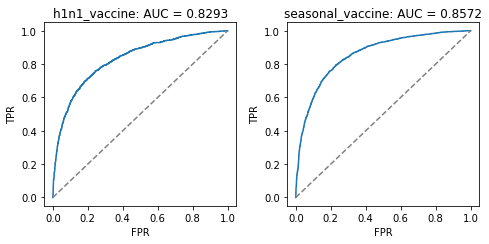

In [87]:
# evaluate results
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_eval['h1n1_vaccine'], 
    preds_rf_gridSearch_h1n1[:, 1], 
    'h1n1_vaccine',
    ax=ax[0]
)
plot_roc(
    y_eval['seasonal_vaccine'], 
    preds_rf_gridSearch_seas[:, 1], 
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

In [88]:
# get parameters of classifier
pprint(f"Best parameters for H1N1 model: {rf_clf_h1n1.best_params_}")
pprint(f"Best parameters for seasonal vaccine model: {rf_clf_seas.best_params_}")

("Best parameters for H1N1 model: {'bootstrap': True, 'max_depth': 30, "
 "'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 20, "
 "'n_estimators': 150}")
("Best parameters for seasonal vaccine model: {'bootstrap': True, 'max_depth': "
 "30, 'max_features': 'auto', 'min_samples_leaf': 8, 'min_samples_split': 15, "
 "'n_estimators': 350}")


In [91]:
# get predictions
y_preds = get_predictions_test_set(rf_clf_h1n1, rf_clf_seas, imputed_test)


In [92]:
# export predictions
y_preds.to_csv('submissions/submission_5.csv')

In [ ]:
# what if I enforce a prior probability of getting vaccine?
# look at prior probabilities of getting vaccine, from training set,
# and make sure that those proportions match up in test set preds?

### Neural Network